In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import calendar as cld
import matplotlib.pyplot as plt
import matplotlib.colors
colors_land = plt.cm.terrain(np.linspace(0.25, 1, 256))
import proplot as pplt # New plot library (https://proplot.readthedocs.io/en/latest/)
pplt.rc['savefig.dpi'] = 300 # 1200 is too big! #https://proplot.readthedocs.io/en/latest/basics.html#Creating-figures
from scipy.stats import chi2
from numba import njit,prange
import matplotlib as mpl
mpl.rcParams['hatch.linewidth'] = 0.05  # previous pdf hatch linewidth
from matplotlib.dates import DateFormatter

from scipy.stats import linregress

In [2]:
normal_format = {'gridlinewidth':0.1, 'gridcolor':'gray8', 'gridalpha':0.5, 'coast':True,'borders':True ,'reso':'hi', 'labels':True, 'lonlines':2, 'latlines':2, 'abc':False, 'latlim':[43.,48.5],'lonlim':[4.,16.]}
multiplot_format = {'gridlinewidth':0.1, 'gridcolor':'gray8', 'gridalpha':0.5, 'coast':True,'borders':True ,'reso':'hi', 'labels':False, 'lonlines':2, 'latlines':2, 'abc':False, 'latlim':[43.,48.5],'lonlim':[4.,16.]}

imin = 32 ; imax = -30
jmin = 20 ; jmax = -15
ds = xr.open_dataset('/bettik/beaumetj/MARout/MAR-ERA-20C/MARgrid_EUf.nc')
lon = ds.LON[jmin:jmax,imin:imax]
lat = ds.LAT[jmin:jmax,imin:imax]
H = np.array(ds.SH[jmin:jmax,imin:imax])

In [3]:
wp_meanseason_meanT = np.load('/bettik/castelli/data/saved_data_MAR_ECEarth3/wp_meanseason_meanT.npy')[:,:,jmin:jmax,imin:imax]
wp_meanseason_meanT_hist = wp_meanseason_meanT[:54,:,:,:]
wp_meanseason_meanT_fut = wp_meanseason_meanT[55:,:,:,:]

wp_meanseason_meanT_50m = np.load('/bettik/castelli/data/saved_data_MAR_ECEarth3/wp_meanseason_meanT_50m.npy')[:,:,jmin:jmax,imin:imax]
wp_meanseason_meanT_50m_hist = wp_meanseason_meanT_50m[:54,:,:,:]
wp_meanseason_meanT_50m_fut = wp_meanseason_meanT_50m[55:,:,:,:]

wp_meanseason_meanT_100m = np.load('/bettik/castelli/data/saved_data_MAR_ECEarth3/wp_meanseason_meanT_100m.npy')[:,:,jmin:jmax,imin:imax]
wp_meanseason_meanT_100m_hist = wp_meanseason_meanT_100m[:54,:,:,:]
wp_meanseason_meanT_100m_fut = wp_meanseason_meanT_100m[55:,:,:,:]

In [4]:
hist = [wp_meanseason_meanT_hist,wp_meanseason_meanT_50m_hist,wp_meanseason_meanT_100m_hist]
fut = [wp_meanseason_meanT_fut,wp_meanseason_meanT_50m_fut,wp_meanseason_meanT_100m_fut]

# 3 heights, 4 seasons, 91x139 pixels
origin_T_hist=np.full((3,4,91,139),np.nan)
slope_T_hist=np.full((3,4,91,139),np.nan)
pvalue_T_hist=np.full((3,4,91,139),np.nan)

origin_T_fut=np.full((3,4,91,139),np.nan)
slope_T_fut=np.full((3,4,91,139),np.nan)
pvalue_T_fut=np.full((3,4,91,139),np.nan)

for i in range(wp_meanseason_meanT.shape[3]):
    # print(str(lon)+'/'+str(les_season_maxT.shape[3]),end=' ')
    for j in range(wp_meanseason_meanT.shape[2]):
        for season in range(4):
            for h in range(0,3):
                # h for height : 2m, 50m or 100m
                linregress_T_hist = linregress(np.arange(hist[h].shape[0]), hist[h][:,season,j,i])
                origin_T_hist[h][season][j][i] = linregress_T_hist.intercept
                slope_T_hist[h][season][j][i] = linregress_T_hist.slope
                pvalue_T_hist[h][season][j][i] = linregress_T_hist.pvalue
                
                linregress_T_fut = linregress(np.arange(fut[h].shape[0]), fut[h][:,season,j,i])
                origin_T_fut[h][season][j][i] = linregress_T_fut.intercept
                slope_T_fut[h][season][j][i] = linregress_T_fut.slope
                pvalue_T_fut[h][season][j][i] = linregress_T_fut.pvalue

In [5]:
def detect_alps(H):
    nlat,nlon = np.shape(H)
    mask = np.bool8(np.zeros((nlat,nlon)))
    r = 4
    for j in range(r,nlat-r):
        for i in range(r,nlon-r):
            mask[j,i] = np.logical_and(H[j,i]>360 ,np.any(H[j-r:j+r,i-r:i+r]>1300))
            # mask[j,i] = np.std(H[j-r:j+r,i-r:i+r])>200
    return mask
alps = detect_alps(H)
alps[lon<4.8] = False
alps[np.logical_and(lon>10,lat<45.2)] = False

north_alps = np.copy(alps)
north_alps[lon>8.6] = False
north_alps[lat<45] = False
#north_alps[lat>46.5] = False

south_alps = np.copy(alps)
south_alps[lat>45] = False

east_alps = np.copy(alps)
east_alps[lon<8.6] = False


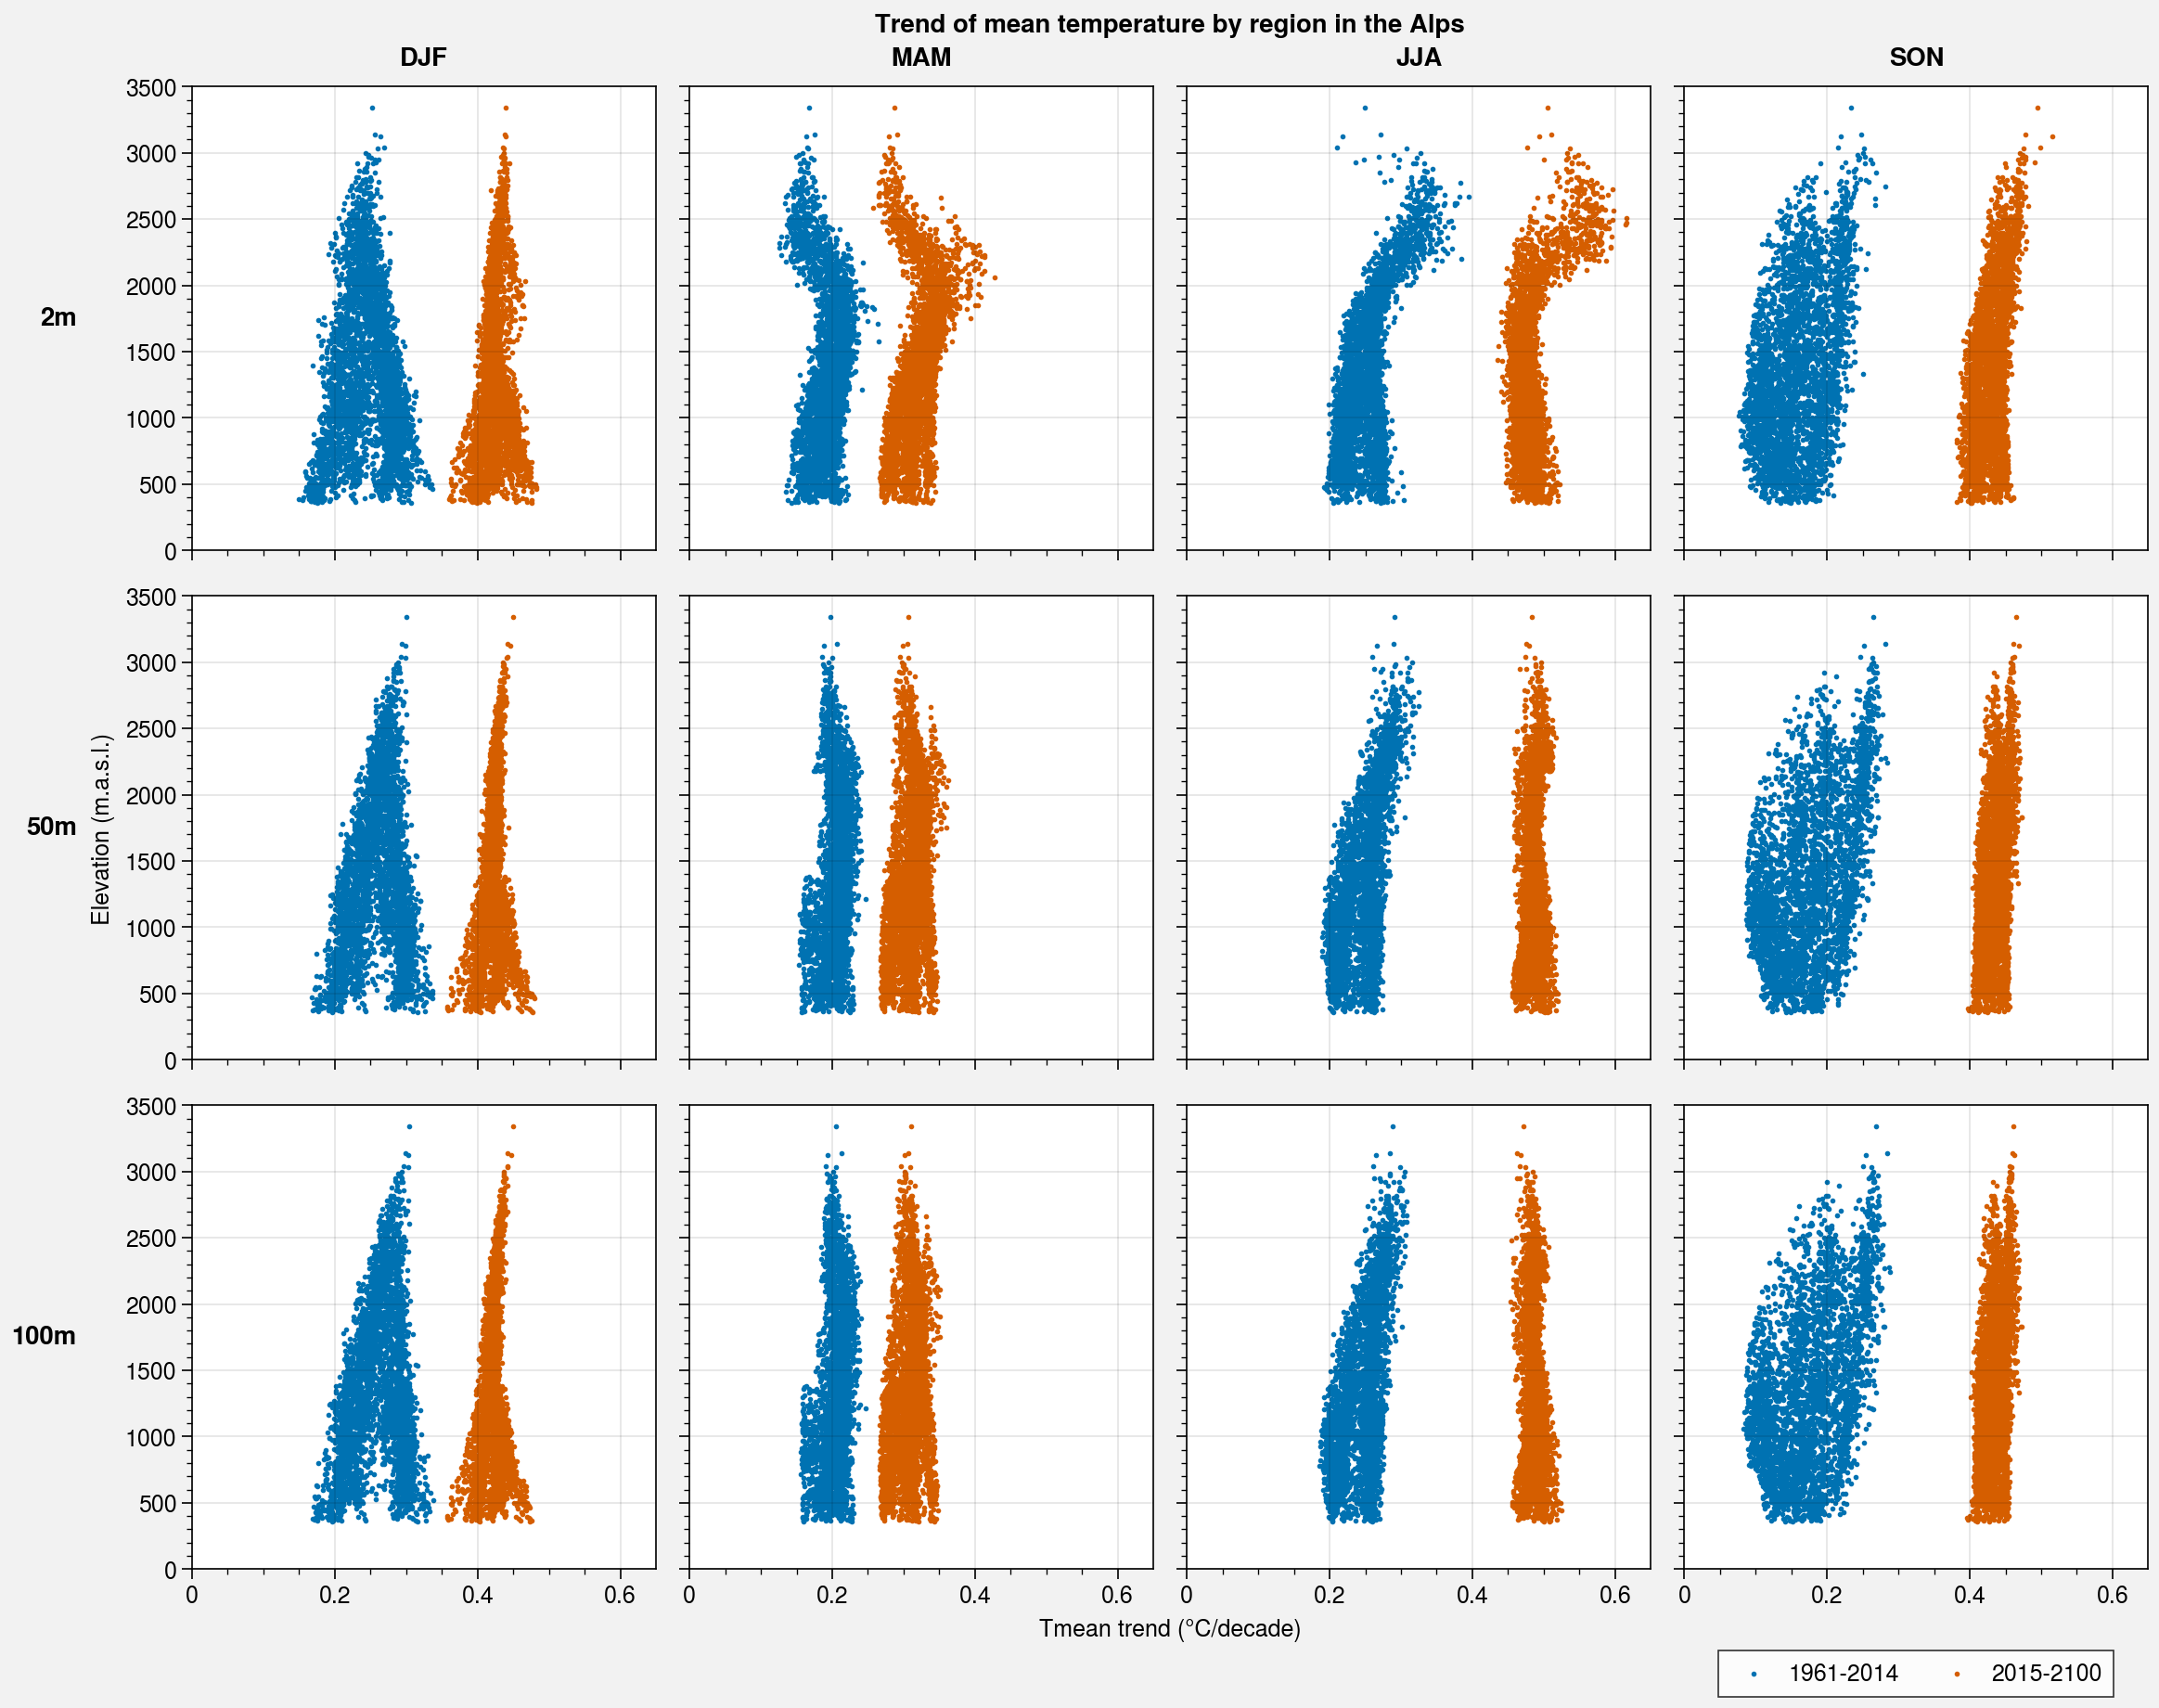

In [7]:
f, axs = pplt.subplots(ncols=4, nrows=3)
leg = ['1961-2014','2015-2100']

for i in range(4):
    slope_T_hist_alps_2m = np.ma.masked_array(slope_T_hist[0,i], mask=np.invert(alps))
    slope_T_hist_alps_50m = np.ma.masked_array(slope_T_hist[1,i], mask=np.invert(alps))
    slope_T_hist_alps_100m = np.ma.masked_array(slope_T_hist[2,i], mask=np.invert(alps))
    
    slopes=[slope_T_hist_alps_2m,slope_T_hist_alps_50m,slope_T_hist_alps_100m]
    
    for j,slope in enumerate(slopes):
        ax = axs[i+4*j]
        blue_dot = ax.scatter(10*slope,ds.SH[jmin:jmax,imin:imax],s=2)
        
    
for i in range(4):
    slope_T_fut_alps_2m = np.ma.masked_array(slope_T_fut[0,i], mask=np.invert(alps))
    slope_T_fut_alps_50m = np.ma.masked_array(slope_T_fut[1,i], mask=np.invert(alps))
    slope_T_fut_alps_100m = np.ma.masked_array(slope_T_fut[2,i], mask=np.invert(alps))
    
    slopes=[slope_T_fut_alps_2m,slope_T_fut_alps_50m,slope_T_fut_alps_100m]
    
    for j,slope in enumerate(slopes):
        ax = axs[i+4*j]
        orange_dot = ax.scatter(10*slope,ds.SH[jmin:jmax,imin:imax],s=2)
        ax.set_xlim((0.,0.65))
        ax.set_ylim((0.,3500))
#        if(j==3):
#            ax.legend([blue_dot,orange_dot],leg,loc='bottom')
ax.legend([blue_dot,orange_dot],leg,loc='bottom')
axs.format(suptitle='Trend of mean temperature by region in the Alps',collabels=['DJF','MAM','JJA', 'SON'],
           rowlabels=['2m','50m','100m'],xlabel='Tmean trend (°C/decade)',ylabel='Elevation (m.a.s.l.)')

In [6]:
# Ajout de coordonnée verticale pression dans le cas de l'atmosphère standard OACI
def z_to_p(H):
    p0 = 1013.25 # hPa
    gamma = 6.5*10**(-3) # K/m
    T0 = 288.5 # K
    g = 9.81 # m.s^-2
    R = 287 # J/kg/K
    pressure = p0*(1-gamma/T0*H)**(g/gamma/R)
    return pressure

P_surf = z_to_p(H)

In [7]:
alps_800 = np.copy(alps)

alps_800[P_surf>820] = False
alps_800[P_surf<780] = False



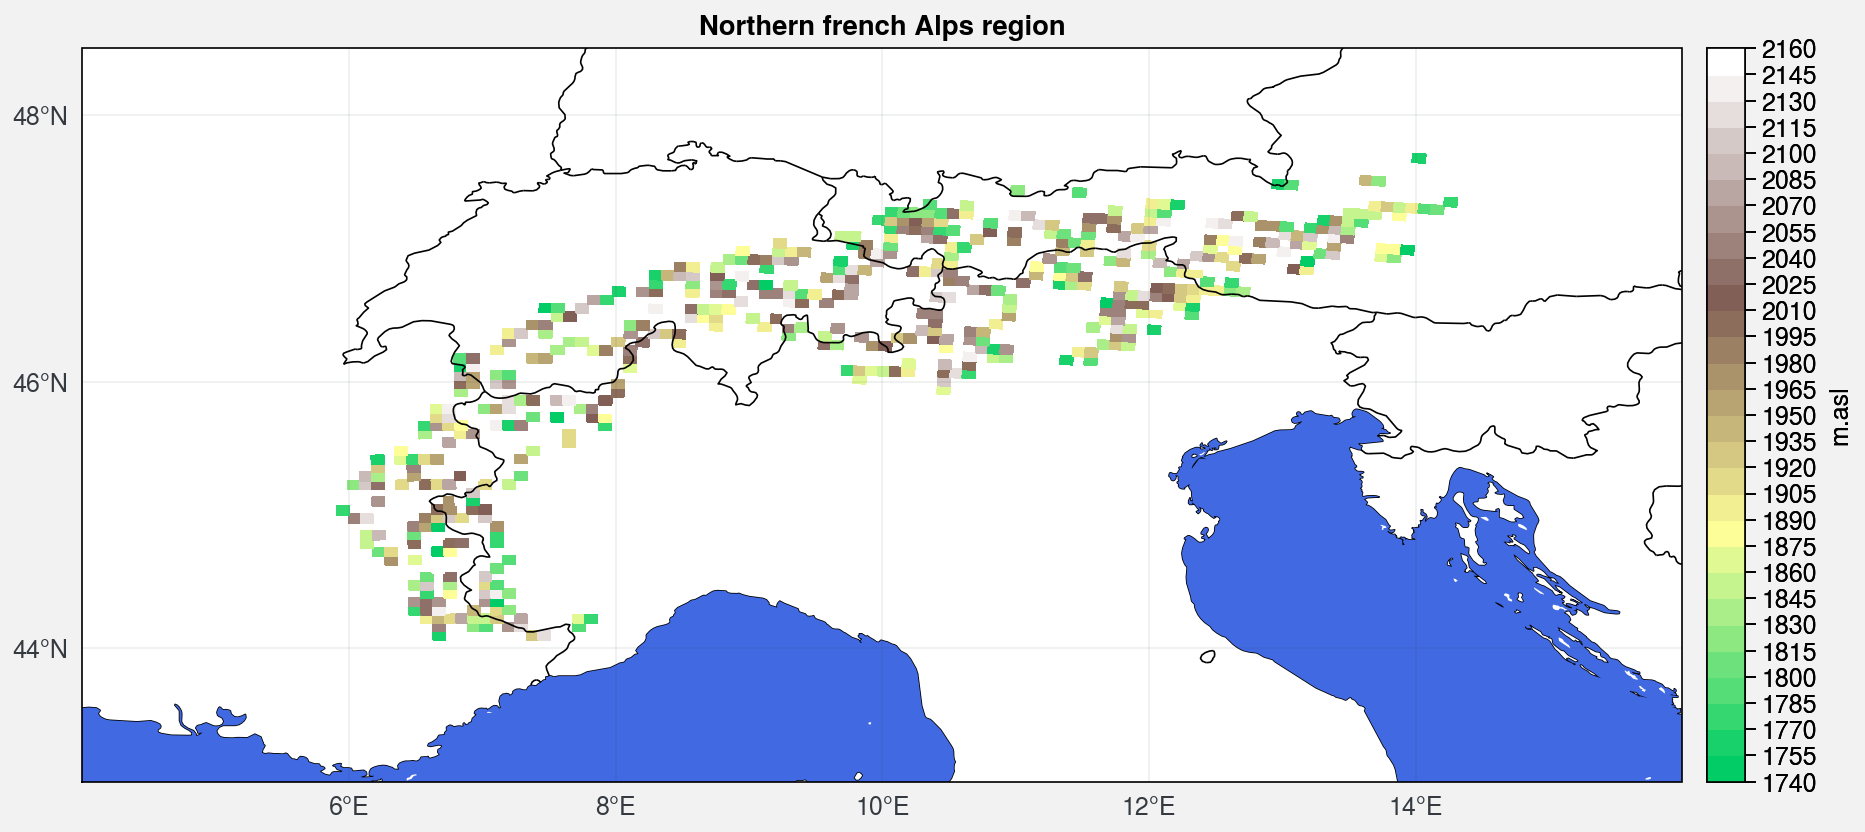

In [8]:
f, ax = pplt.subplots(proj='cyl', axwidth=8)
m=ax.pcolormesh(lon, lat, np.ma.masked_array(H,mask=np.invert(alps_800)), levels=34,cmap=colors_land)
f.colorbar(m,label= 'm.asl')

#ax.contour(lon, lat,north_french_alps)
ax.format(**normal_format,suptitle='Northern french Alps region')
ax.format(ocean=True,oceancolor='royalblue',reso='hi')#, latlim=[40.,51.],lonlim=[0.,20.])

In [9]:
wp_meanseason_meanSP = np.load('/bettik/castelli/data/saved_data_MAR_ECEarth3/wp_meanseason_meanSP.npy')[:,:,jmin:jmax,imin:imax]

wp_meanseason_meanSP.shape

(140, 4, 91, 139)

In [10]:
meanSP = wp_meanseason_meanSP.mean(axis=(0,1))
meanSP.shape

(91, 139)

In [11]:
new_alps_800 = np.copy(alps)

new_alps_800[meanSP>820] = False
new_alps_800[meanSP<780] = False

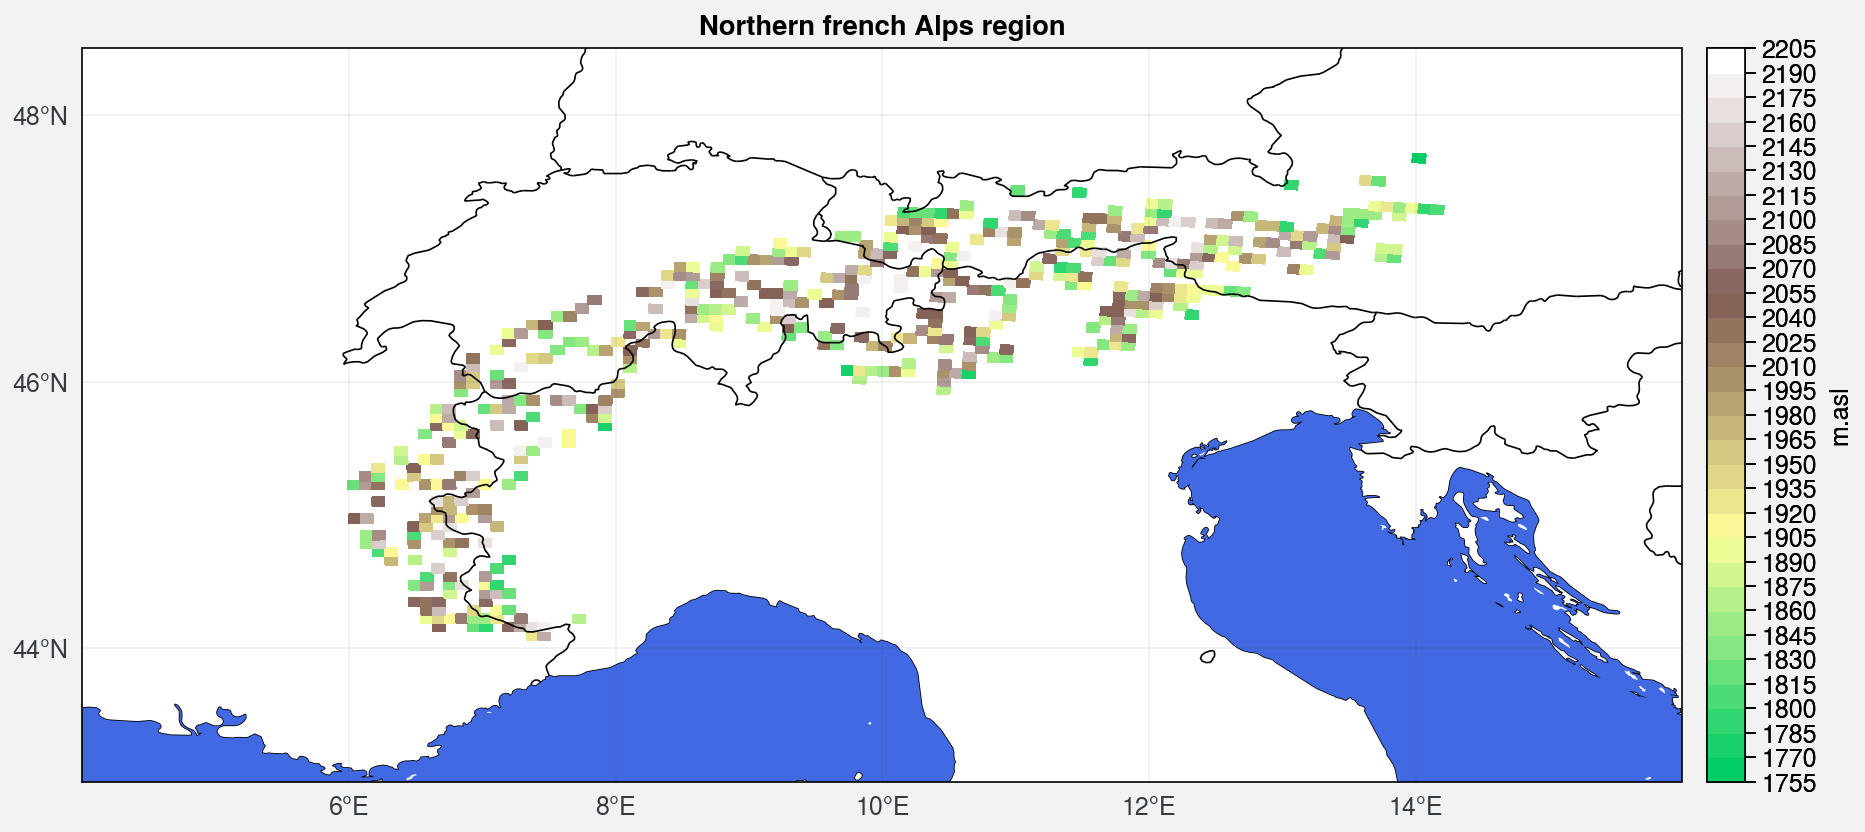

In [12]:
f, ax = pplt.subplots(proj='cyl', axwidth=8)
m=ax.pcolormesh(lon, lat, np.ma.masked_array(H,mask=np.invert(new_alps_800)), levels=34,cmap=colors_land)
f.colorbar(m,label= 'm.asl')

#ax.contour(lon, lat,north_french_alps)
ax.format(**normal_format,suptitle='Northern french Alps region')
ax.format(ocean=True,oceancolor='royalblue',reso='hi')#, latlim=[40.,51.],lonlim=[0.,20.])

Temperature data at 800 hPa (and other pressure levels).

Some grid points have no value at 800hPa (because surface is already at lower pressure). These grid points have a value of 9.96920997e+36. When computing trend, the trend will be equal to 0. Some grid points are right at the limit of 800 hPa, so they sometimes have a (real) value and sometimes not. When computing the trend, this gives unrealistically high values (positive or negative).

In [12]:
wp_meanseason_meanTTp = np.full((7,140,4,91,139),np.nan)

wp_meanseason_meanTTp[0] = np.load('/bettik/castelli/data/saved_data_MAR_ECEarth3/wp_meanseason_meanTTp_925.npy')[:,:,jmin:jmax,imin:imax]
wp_meanseason_meanTTp[1] = np.load('/bettik/castelli/data/saved_data_MAR_ECEarth3/wp_meanseason_meanTTp_850.npy')[:,:,jmin:jmax,imin:imax]
wp_meanseason_meanTTp[2] = np.load('/bettik/castelli/data/saved_data_MAR_ECEarth3/wp_meanseason_meanTTp_800.npy')[:,:,jmin:jmax,imin:imax]
wp_meanseason_meanTTp[3] = np.load('/bettik/castelli/data/saved_data_MAR_ECEarth3/wp_meanseason_meanTTp_700.npy')[:,:,jmin:jmax,imin:imax]
wp_meanseason_meanTTp[4] = np.load('/bettik/castelli/data/saved_data_MAR_ECEarth3/wp_meanseason_meanTTp_600.npy')[:,:,jmin:jmax,imin:imax]
wp_meanseason_meanTTp[5] = np.load('/bettik/castelli/data/saved_data_MAR_ECEarth3/wp_meanseason_meanTTp_500.npy')[:,:,jmin:jmax,imin:imax]
wp_meanseason_meanTTp[6] = np.load('/bettik/castelli/data/saved_data_MAR_ECEarth3/wp_meanseason_meanTTp_200.npy')[:,:,jmin:jmax,imin:imax]

In [13]:

origin_TTp_hist=np.full((7,4,91,139),np.nan)
slope_TTp_hist=np.full((7,4,91,139),np.nan)
pvalue_TTp_hist=np.full((7,4,91,139),np.nan)

origin_TTp_fut=np.full((7,4,91,139),np.nan)
slope_TTp_fut=np.full((7,4,91,139),np.nan)
pvalue_TTp_fut=np.full((7,4,91,139),np.nan)

# pressures = [925,850,800,700,600,500,200]

for i in range(139):
    # print(str(lon)+'/'+str(les_season_maxT.shape[3]),end=' ')
    print(i,end=' ')
    for j in range(91):
        for season in range(4):
            for P in range(7):
                linregress_T_hist = linregress(np.arange(54), wp_meanseason_meanTTp[P,:54,season,j,i]) #hist : 1961-2014, 54 years
                origin_TTp_hist[P][season][j][i] = linregress_T_hist.intercept
                slope_TTp_hist[P][season][j][i] = linregress_T_hist.slope
                pvalue_TTp_hist[P][season][j][i] = linregress_T_hist.pvalue
            
                linregress_T_fut = linregress(np.arange(85), wp_meanseason_meanTTp[P,55:,season,j,i]) #fut : 2015-2100, 85 years
                origin_TTp_fut[P][season][j][i] = linregress_T_fut.intercept
                slope_TTp_fut[P][season][j][i] = linregress_T_fut.slope
                pvalue_TTp_fut[P][season][j][i] = linregress_T_fut.pvalue

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 

In [14]:
alps_SP_925 = np.copy(alps)
alps_SP_850 = np.copy(alps)
alps_SP_800 = np.copy(alps)
alps_SP_700 = np.copy(alps)
alps_SP_600 = np.copy(alps)
alps_SP_500 = np.copy(alps)
alps_SP_200 = np.copy(alps)

alps_SP_925[meanSP>945] = False
alps_SP_925[meanSP<905] = False

alps_SP_850[meanSP>870] = False
alps_SP_850[meanSP<830] = False

alps_SP_800[meanSP>820] = False
alps_SP_800[meanSP<780] = False

alps_SP_700[meanSP>720] = False
alps_SP_700[meanSP<680] = False

alps_SP_600[meanSP>620] = False
alps_SP_600[meanSP<580] = False

alps_SP_500[meanSP>520] = False
alps_SP_500[meanSP<480] = False

alps_SP = [alps_SP_925,alps_SP_850,alps_SP_800,alps_SP_700,alps_SP_600,alps_SP_500,alps_SP_200]

In [15]:
# mask for under-the-surface values at 800hPa and other pressures

msk_925 = (wp_meanseason_meanTTp[0].mean(axis=0) < 1000) # 1000 :  arbitrary value, we just want to filter out the 10**(34) values
msk_850 = (wp_meanseason_meanTTp[1].mean(axis=0) < 1000)
msk_800 = (wp_meanseason_meanTTp[2].mean(axis=0) < 1000)
msk_700 = (wp_meanseason_meanTTp[3].mean(axis=0) < 1000)
msk_600 = (wp_meanseason_meanTTp[4].mean(axis=0) < 1000)
msk_500 = (wp_meanseason_meanTTp[5].mean(axis=0) < 1000)
msk_200 = (wp_meanseason_meanTTp[6].mean(axis=0) < 1000)

alps_TTp_925 = np.logical_and(alps,msk_925)
alps_TTp_850 = np.logical_and(alps,msk_850)
alps_TTp_800 = np.logical_and(alps,msk_800)
alps_TTp_700 = np.logical_and(alps,msk_700)
alps_TTp_600 = np.logical_and(alps,msk_600)
alps_TTp_500 = np.logical_and(alps,msk_500)
alps_TTp_200 = np.logical_and(alps,msk_200)

alps_TTp = [alps_TTp_925,alps_TTp_850,alps_TTp_800,alps_TTp_700,alps_TTp_600,alps_TTp_500,alps_TTp_200]

In [16]:
alps_TTp.shape

AttributeError: 'list' object has no attribute 'shape'

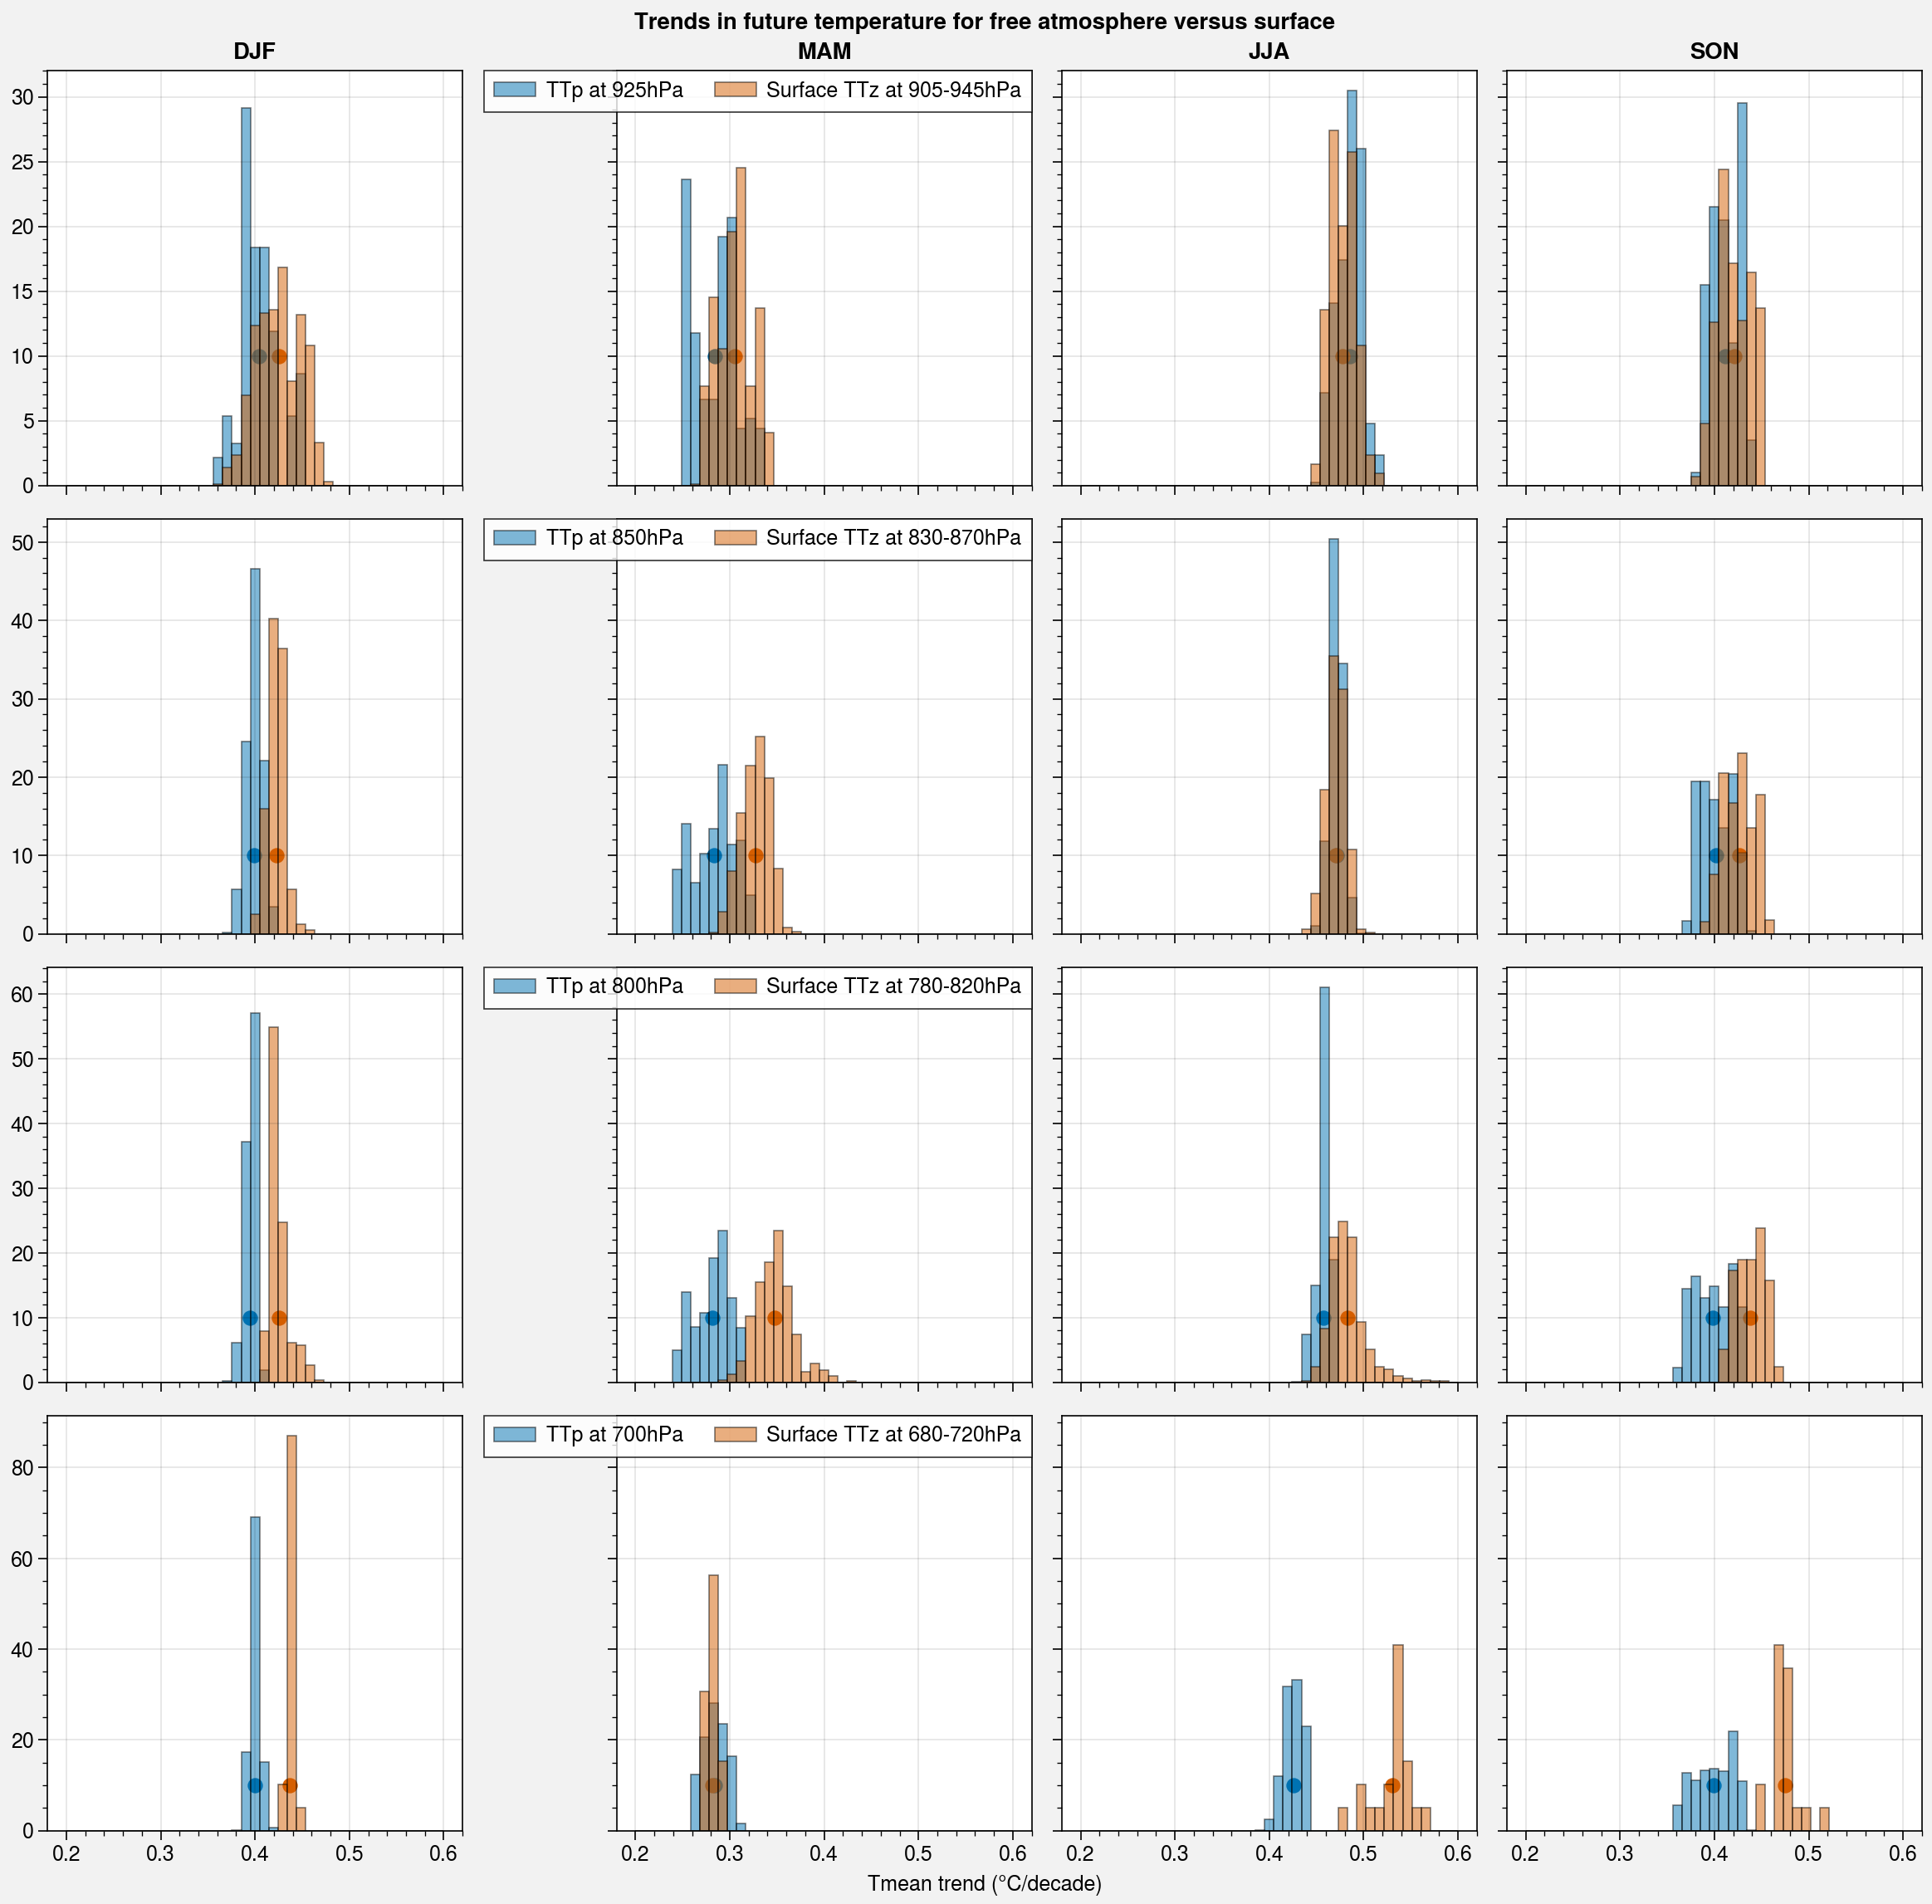

In [17]:
f, axs = pplt.subplots(ncols=4,nrows=4)
leg = [['TTp at 925hPa','TTp at 850hPa','TTp at 800hPa','TTp at 700hPa','TTp at 600hPa'],
       ['Surface TTz at 905-945hPa','Surface TTz at 830-870hPa','Surface TTz at 780-820hPa','Surface TTz at 680-720hPa',
        'Surface TTz at 580-620hPa']]


for i in range(4): # seasons
    for j in range(4): # P levels
        slope_TTp = np.ma.masked_array(slope_TTp_fut[j,i], mask=np.invert(alps_TTp[j][i])).reshape(12649)
        slope_surf = np.ma.masked_array(slope_T_fut[0,i], mask=np.invert(alps_SP[j])).reshape(12649)
        ax = axs[j,i]
        blue_bar = ax.hist(10*slope_TTp,bins=41,range=(0.2,0.6),density=True,alpha=0.5,label=leg[0][j])
        orange_bar = ax.hist(10*slope_surf,bins=41,range=(0.2,0.6),density=True,alpha=0.5,label=leg[1][j])
        
        ax.scatter(10*slope_TTp.mean(),10)
        ax.scatter(10*slope_surf.mean(),10)
        
        if(i == 1):
            ax.legend()
    
    #ax.legend([blue_bar,orange_bar],leg


axs.format(suptitle='Trends in future temperature for free atmosphere versus surface',
           collabels=['DJF','MAM','JJA', 'SON'],xlabel='Tmean trend (°C/decade)')


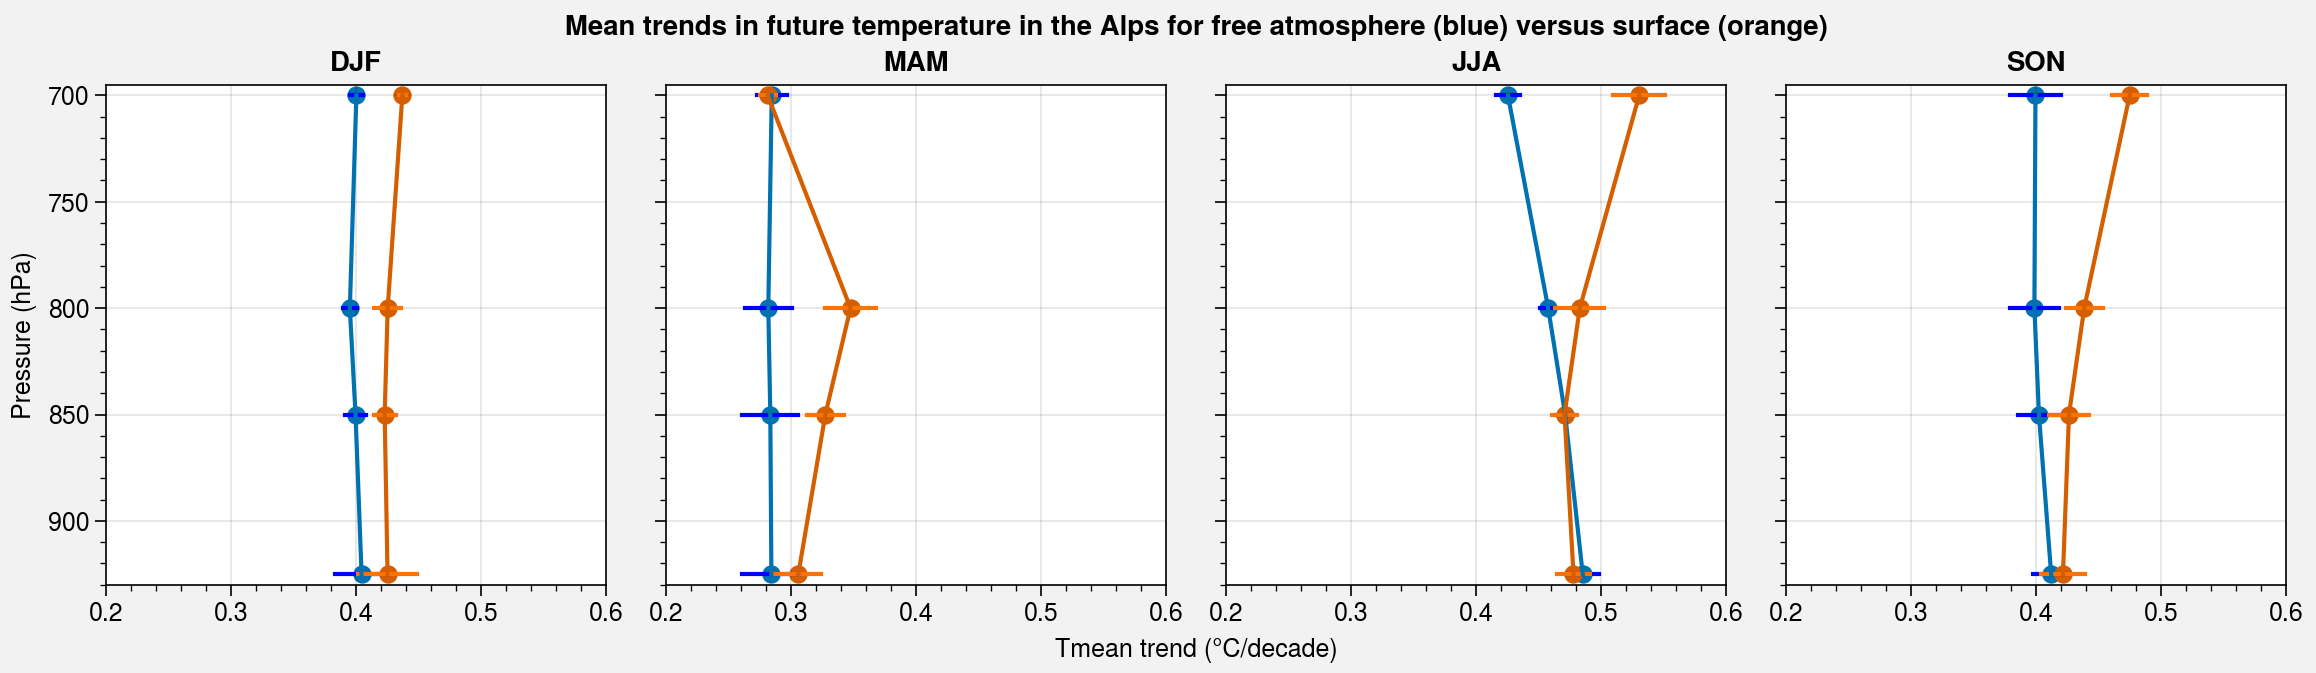

In [26]:
f, axs = pplt.subplots(ncols=4)

mean_slope_TTp=np.full((4,4),np.nan)
mean_slope_surf=np.full((4,4),np.nan)

std_slope_TTp=np.full((4,4),np.nan)
std_slope_surf=np.full((4,4),np.nan)

pressure = [925,850,800,700]

for i in range(4): # seasons
    ax = axs[i]
    for j in range(4): # P levels
        slope_TTp = np.ma.masked_array(slope_TTp_fut[j,i], mask=np.invert(alps_TTp[j][i])).reshape(12649)
        slope_surf = np.ma.masked_array(slope_T_fut[0,i], mask=np.invert(alps_SP[j])).reshape(12649)
        
        mean_slope_TTp[i,j] = 10*slope_TTp.mean()
        std_slope_TTp[i,j] = 10*slope_TTp.std()
        mean_slope_surf[i,j] = 10*slope_surf.mean()
        std_slope_surf[i,j] = 10*slope_surf.std()
        
        ax.plot([10*slope_TTp.mean()-10*slope_TTp.std(),10*slope_TTp.mean()+10*slope_TTp.std()],[pressure[j],pressure[j]],c='b')
        ax.plot([10*slope_surf.mean()-10*slope_surf.std(),10*slope_surf.mean()+10*slope_surf.std()],[pressure[j],pressure[j]],c='orange')
        
    
    
    ax.plot(mean_slope_TTp[i,:],pressure,label='Free atmosphere')
    ax.plot(mean_slope_surf[i,:],pressure,label='Surface')
    ax.scatter(mean_slope_TTp[i,:],pressure,label='Free atmosphere')
    ax.scatter(mean_slope_surf[i,:],pressure,label='Surface')
    
    
    ax.set_xlim(0.2,0.6)
    ax.set_ylim(930,695)
        
    #if(i == 1):
    #    ax.legend()
    
    #ax.legend([blue_bar,orange_bar],leg


axs.format(suptitle='Mean trends in future temperature in the Alps for free atmosphere (blue) versus surface (orange)',
           collabels=['DJF','MAM','JJA', 'SON'],xlabel='Tmean trend (°C/decade)',ylabel='Pressure (hPa)')

Text(0, 0.5, '°C')

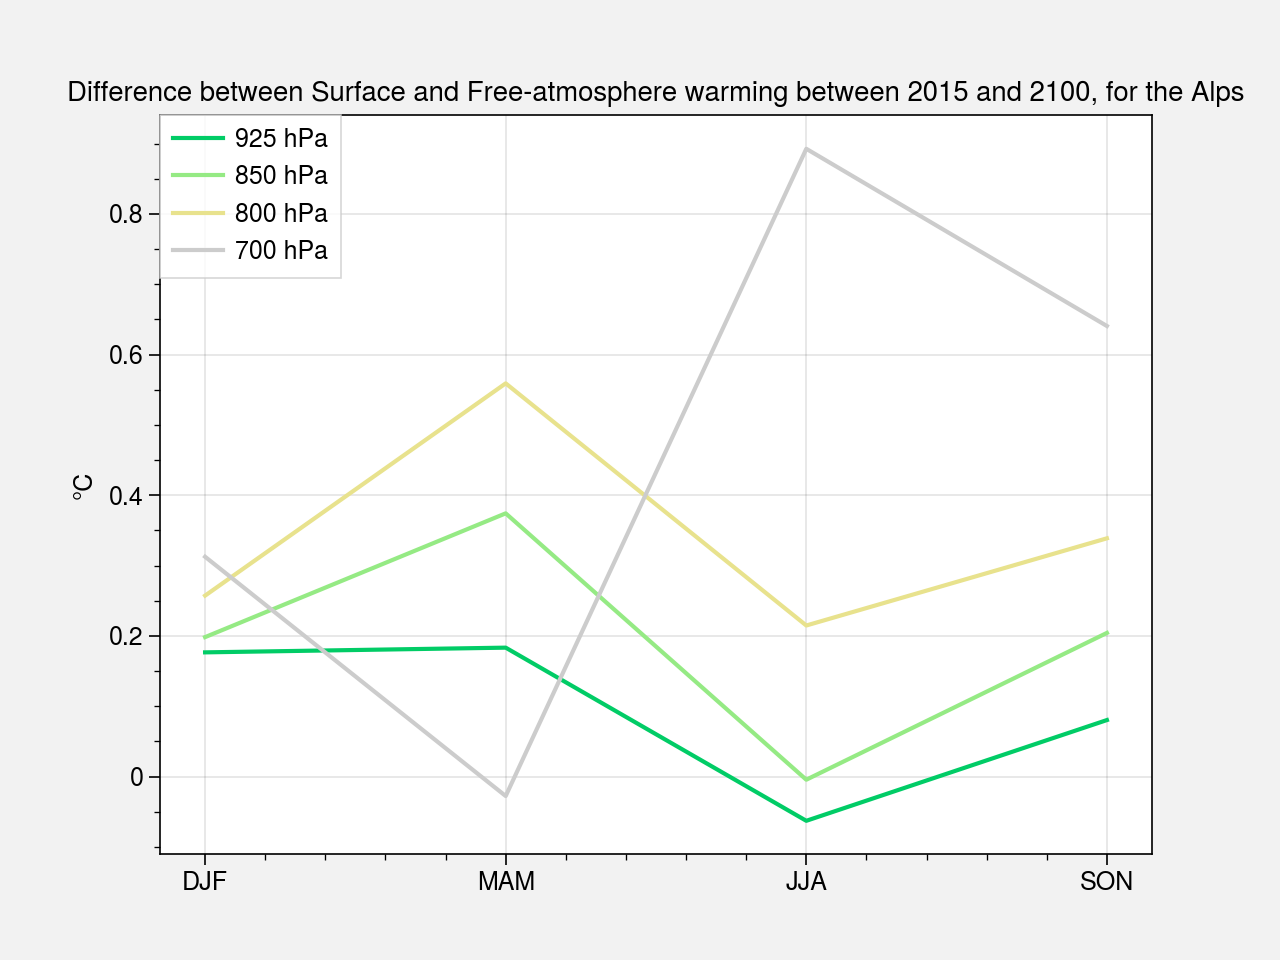

In [109]:
seasons = ['DJF','MAM','JJA', 'SON']
color_levels = [colors_land[0],colors_land[50],colors_land[100],np.array([0.8,0.8,0.8,1.])]
leg = ['925 hPa','850 hPa','800 hPa','700 hPa']

for P in range(4):
    plt.plot(seasons,8.5*(mean_slope_surf[:,P]-mean_slope_TTp[:,P]),c=color_levels[P],label=leg[P]) # 8.5 décennies ou 85 ans
plt.legend()
plt.title('Difference between Surface and Free-atmosphere warming between 2015 and 2100, for the Alps')
plt.ylabel('°C')

In [101]:
colors_land

array([[0.00392157, 0.80078431, 0.40078431, 1.        ],
       [0.00392157, 0.80078431, 0.40078431, 1.        ],
       [0.01960784, 0.80392157, 0.40392157, 1.        ],
       ...,
       [0.99215686, 0.98996078, 0.9894902 , 1.        ],
       [1.        , 1.        , 1.        , 1.        ],
       [1.        , 1.        , 1.        , 1.        ]])

In [13]:
# generalize mask to whole period

alps_wp = np.repeat(alps[np.newaxis,:,:],4,axis=0)
alps_wp = np.repeat(alps_wp[np.newaxis,:,:,:],140,axis=0)
alps_wp.shape

(140, 4, 91, 139)

In [14]:

msk_925_wp = np.repeat(msk_925[np.newaxis,:,:,:],140,axis=0)
msk_850_wp = np.repeat(msk_850[np.newaxis,:,:,:],140,axis=0)
msk_800_wp = np.repeat(msk_800[np.newaxis,:,:,:],140,axis=0)
msk_700_wp = np.repeat(msk_700[np.newaxis,:,:,:],140,axis=0)
msk_600_wp = np.repeat(msk_600[np.newaxis,:,:,:],140,axis=0)
msk_500_wp = np.repeat(msk_500[np.newaxis,:,:,:],140,axis=0)
msk_200_wp = np.repeat(msk_200[np.newaxis,:,:,:],140,axis=0)

In [15]:
alps_925_wp = np.logical_and(alps_wp,msk_925_wp)
alps_850_wp = np.logical_and(alps_wp,msk_850_wp)
alps_800_wp = np.logical_and(alps_wp,msk_800_wp)
alps_700_wp = np.logical_and(alps_wp,msk_700_wp)
alps_600_wp = np.logical_and(alps_wp,msk_600_wp)
alps_500_wp = np.logical_and(alps_wp,msk_500_wp)
alps_200_wp = np.logical_and(alps_wp,msk_200_wp)

In [16]:
alps_800_wp.shape

(140, 4, 91, 139)

In [17]:
# sur les Alpes

wp_meanseason_meanTTp_925_alps = np.ma.array(wp_meanseason_meanTTp_925,mask=np.invert(alps_925_wp))
wp_meanseason_meanTTp_850_alps = np.ma.array(wp_meanseason_meanTTp_850,mask=np.invert(alps_850_wp))
wp_meanseason_meanTTp_800_alps = np.ma.array(wp_meanseason_meanTTp_800,mask=np.invert(alps_800_wp))
wp_meanseason_meanTTp_700_alps = np.ma.array(wp_meanseason_meanTTp_700,mask=np.invert(alps_700_wp))
wp_meanseason_meanTTp_600_alps = np.ma.array(wp_meanseason_meanTTp_600,mask=np.invert(alps_600_wp))
wp_meanseason_meanTTp_500_alps = np.ma.array(wp_meanseason_meanTTp_500,mask=np.invert(alps_500_wp))
wp_meanseason_meanTTp_200_alps = np.ma.array(wp_meanseason_meanTTp_200,mask=np.invert(alps_200_wp))


wp_meanseason_meanTTp_925_meanalps = wp_meanseason_meanTTp_925_alps.mean(axis=(2,3))
wp_meanseason_meanTTp_850_meanalps = wp_meanseason_meanTTp_850_alps.mean(axis=(2,3))
wp_meanseason_meanTTp_800_meanalps = wp_meanseason_meanTTp_800_alps.mean(axis=(2,3))
wp_meanseason_meanTTp_700_meanalps = wp_meanseason_meanTTp_700_alps.mean(axis=(2,3))
wp_meanseason_meanTTp_600_meanalps = wp_meanseason_meanTTp_600_alps.mean(axis=(2,3))
wp_meanseason_meanTTp_500_meanalps = wp_meanseason_meanTTp_500_alps.mean(axis=(2,3))
wp_meanseason_meanTTp_200_meanalps = wp_meanseason_meanTTp_200_alps.mean(axis=(2,3))

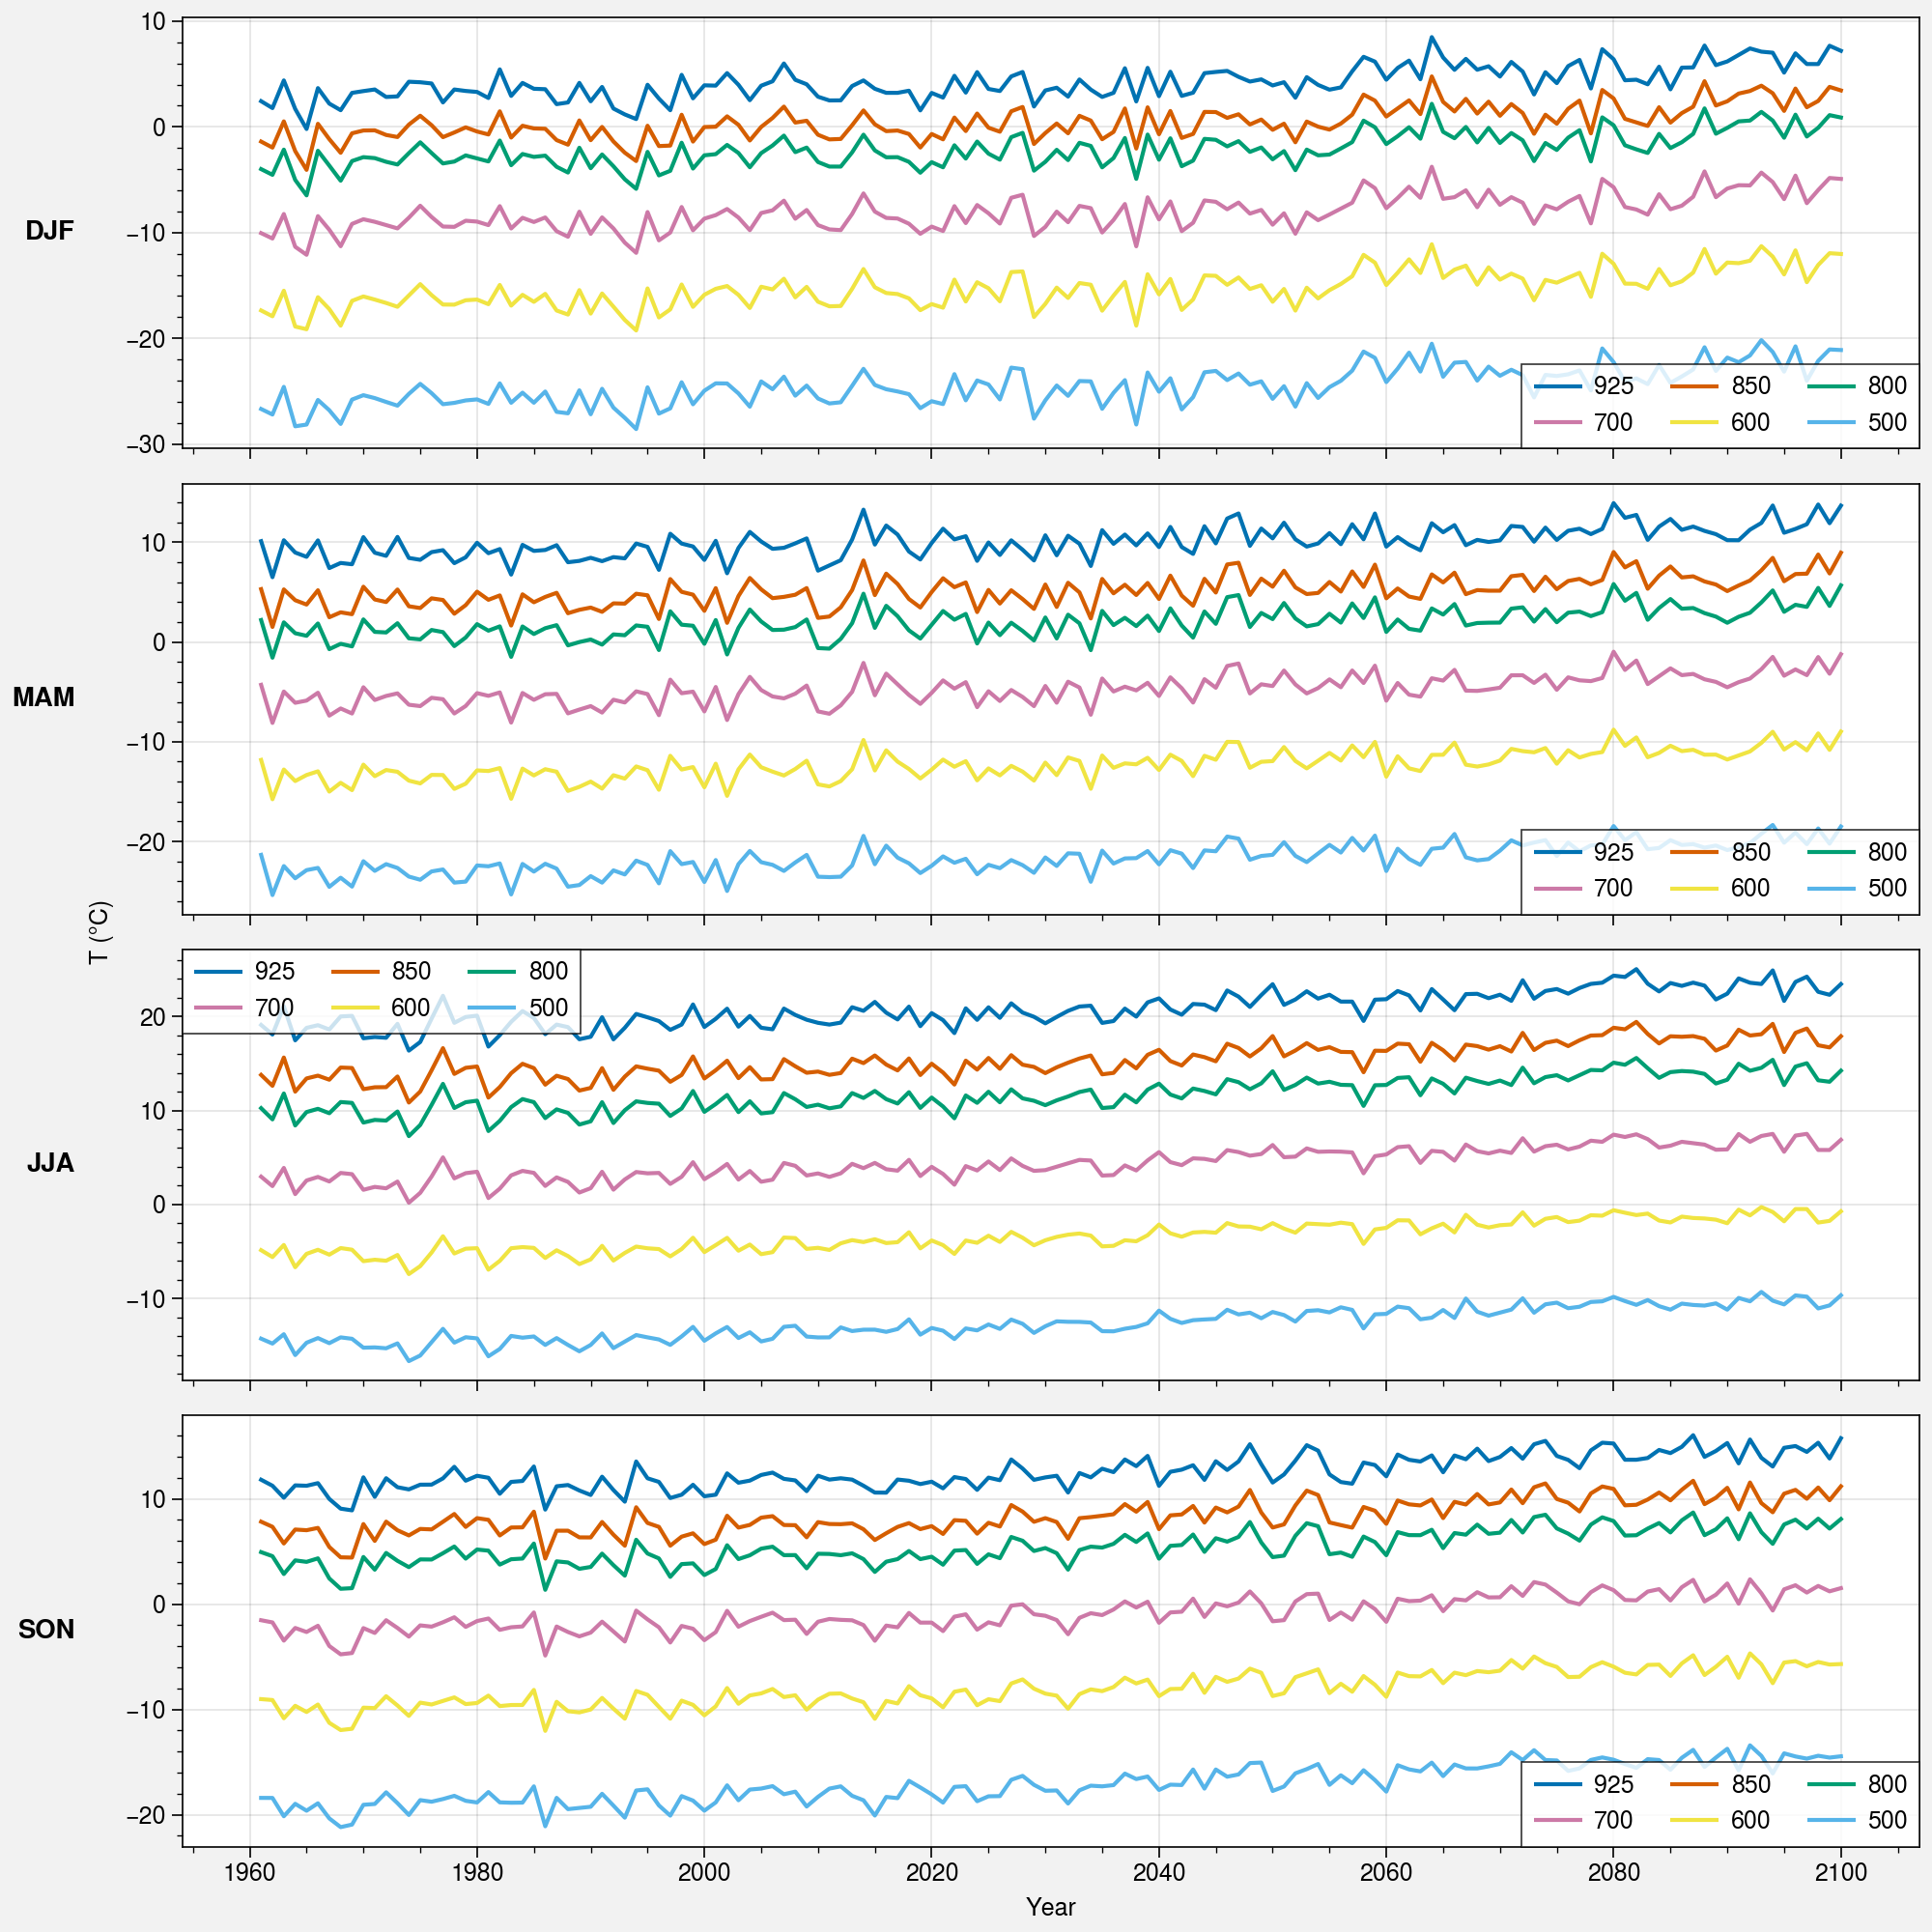

In [18]:
f,axs = pplt.subplots(nrows=4,figsize=(10,10))

for season in range(4):
    ax = axs[season]
    ax.plot(np.arange(1961,2101),wp_meanseason_meanTTp_925_meanalps[:,season],label='925')
    ax.plot(np.arange(1961,2101),wp_meanseason_meanTTp_850_meanalps[:,season],label='850')
    ax.plot(np.arange(1961,2101),wp_meanseason_meanTTp_800_meanalps[:,season],label='800')
    ax.plot(np.arange(1961,2101),wp_meanseason_meanTTp_700_meanalps[:,season],label='700')
    ax.plot(np.arange(1961,2101),wp_meanseason_meanTTp_600_meanalps[:,season],label='600')
    ax.plot(np.arange(1961,2101),wp_meanseason_meanTTp_500_meanalps[:,season],label='500')
#    ax.plot(np.arange(1961,2101),wp_meanseason_meanTTp_200_meanalps[:,season],label='200')
#    ax.set_ylim((-7,16))

axs.legend()
axs.format(rowlabels=['DJF','MAM','JJA', 'SON'],xlabel='Year',ylabel='T (°C)')

Altitude levels

In [19]:
levels = [np.logical_and(alps,H<1000) , 
               np.logical_and(alps,np.logical_and(H>=1000,H<1500)),
               np.logical_and(alps,np.logical_and(H>=1500,H<2000)),
               np.logical_and(alps,np.logical_and(H>=2000,H<2500)),
               np.logical_and(alps,H>=2500),
         alps]
name_levels = ["< 1000","1000-1500","1500-2000","2000-2500","> 2500","all"]
surface_levels = np.array([np.sum(lev) for lev in levels])
frac_levels = np.array([np.sum(lev)/np.sum(alps) for lev in levels])
color_levels = [colors_land[0],colors_land[50],colors_land[100],colors_land[180],np.array([0.8,0.8,0.8,1.]),np.array([0.,0.,0.,1.]) ]
def print_rgb(rgb):
    print(rgb,end=' ')
    print(str(int(rgb[0]*255))+';'+str(int(rgb[1]*255))+';'+str(int(rgb[2]*255)),end=' ')
    print('\x1b[38;2;'+str(int(rgb[0]*255))+';'+str(int(rgb[1]*255))+';'+str(int(rgb[2]*255))+'m'+'██████'+'\x1b[0m')
for c in color_levels:
    print_rgb(c)

[0.00392157 0.80078431 0.40078431 1.        ] 1;204;102 ██████
[0.58431373 0.91686275 0.51686275 1.        ] 149;233;131 ██████
[0.90980392 0.88454902 0.55129412 1.        ] 232;225;140 ██████
[0.56078431 0.43780392 0.41145098 1.        ] 143;111;104 ██████
[0.8 0.8 0.8 1. ] 204;204;204 ██████
[0. 0. 0. 1.] 0;0;0 ██████


In [20]:
np.logical_and(alps,H<1000).sum()

1162

In [21]:
np.logical_and(alps,H<500).sum()

159

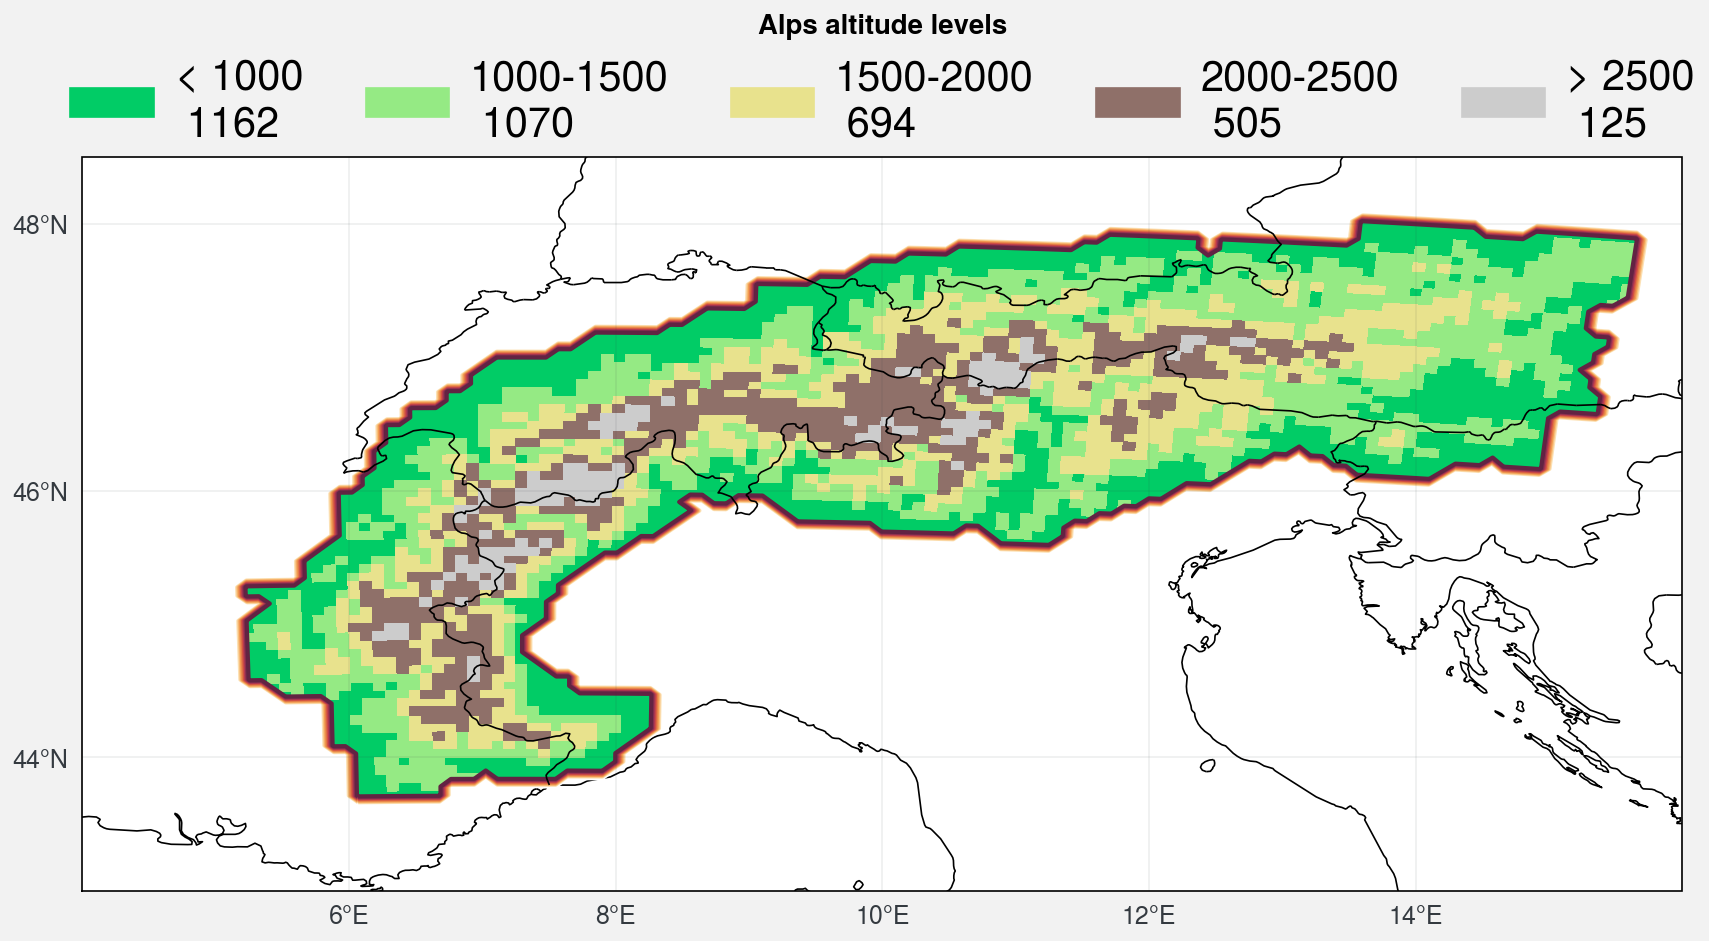

In [48]:
f, ax = pplt.subplots(proj='cyl', axwidth=8)
for i,lev in enumerate(levels[:-1]):
    ax.pcolormesh(lon, lat,np.ma.masked_array(lev,mask=np.logical_not(lev)) ,cmap=matplotlib.colors.ListedColormap([color_levels[i]]),
                  edgecolors='none')
ax.contour(lon, lat,alps)
ax.format(**normal_format,suptitle='Alps altitude levels')
import matplotlib.patches as mpatches
ax.legend(handles=
          [ mpatches.Patch(color=color_levels[i],label=name_levels[i]+'\n {:}'.format(np.sum(levels[i]))) for i in range(5)],
          fontsize=15, ncols=5, center=True, frame=False, loc='t')

In [22]:
wp_meanseason_meanT_100m.shape

(140, 4, 91, 139)

In [23]:
np.logical_and(alps_wp,H<1000).shape

(140, 4, 91, 139)

In [24]:
print(z_to_p(1000))
print(z_to_p(1500))
print(z_to_p(2000))
print(z_to_p(2500))

898.8212761592608
845.6684140540792
795.0902028909093
746.9901101440548


In [25]:
levels_wp = [np.logical_and(alps_wp,H<1000) , 
               np.logical_and(alps_wp,np.logical_and(H>=1000,H<1500)),
               np.logical_and(alps_wp,np.logical_and(H>=1500,H<2000)),
               np.logical_and(alps_wp,np.logical_and(H>=2000,H<2500)),
               np.logical_and(alps_wp,H>=2500),
         alps_wp]

meanseason_meanT_levels = [np.ma.masked_array(wp_meanseason_meanT,mask=np.invert(levels_wp[0])).mean(axis=(2,3)),
                           np.ma.masked_array(wp_meanseason_meanT,mask=np.invert(levels_wp[1])).mean(axis=(2,3)),
                           np.ma.masked_array(wp_meanseason_meanT,mask=np.invert(levels_wp[2])).mean(axis=(2,3)),
                           np.ma.masked_array(wp_meanseason_meanT,mask=np.invert(levels_wp[3])).mean(axis=(2,3)),
                           np.ma.masked_array(wp_meanseason_meanT,mask=np.invert(levels_wp[4])).mean(axis=(2,3)),
                           np.ma.masked_array(wp_meanseason_meanT,mask=np.invert(levels_wp[5])).mean(axis=(2,3))]

meanseason_meanT_100m_levels = [np.ma.masked_array(wp_meanseason_meanT_100m,mask=np.invert(levels_wp[0])).mean(axis=(2,3)),
                           np.ma.masked_array(wp_meanseason_meanT_100m,mask=np.invert(levels_wp[1])).mean(axis=(2,3)),
                           np.ma.masked_array(wp_meanseason_meanT_100m,mask=np.invert(levels_wp[2])).mean(axis=(2,3)),
                           np.ma.masked_array(wp_meanseason_meanT_100m,mask=np.invert(levels_wp[3])).mean(axis=(2,3)),
                           np.ma.masked_array(wp_meanseason_meanT_100m,mask=np.invert(levels_wp[4])).mean(axis=(2,3)),
                           np.ma.masked_array(wp_meanseason_meanT_100m,mask=np.invert(levels_wp[5])).mean(axis=(2,3))]

seasons = ['DJF','MAM','JJA','SON']

time = np.arange(1961,2101)

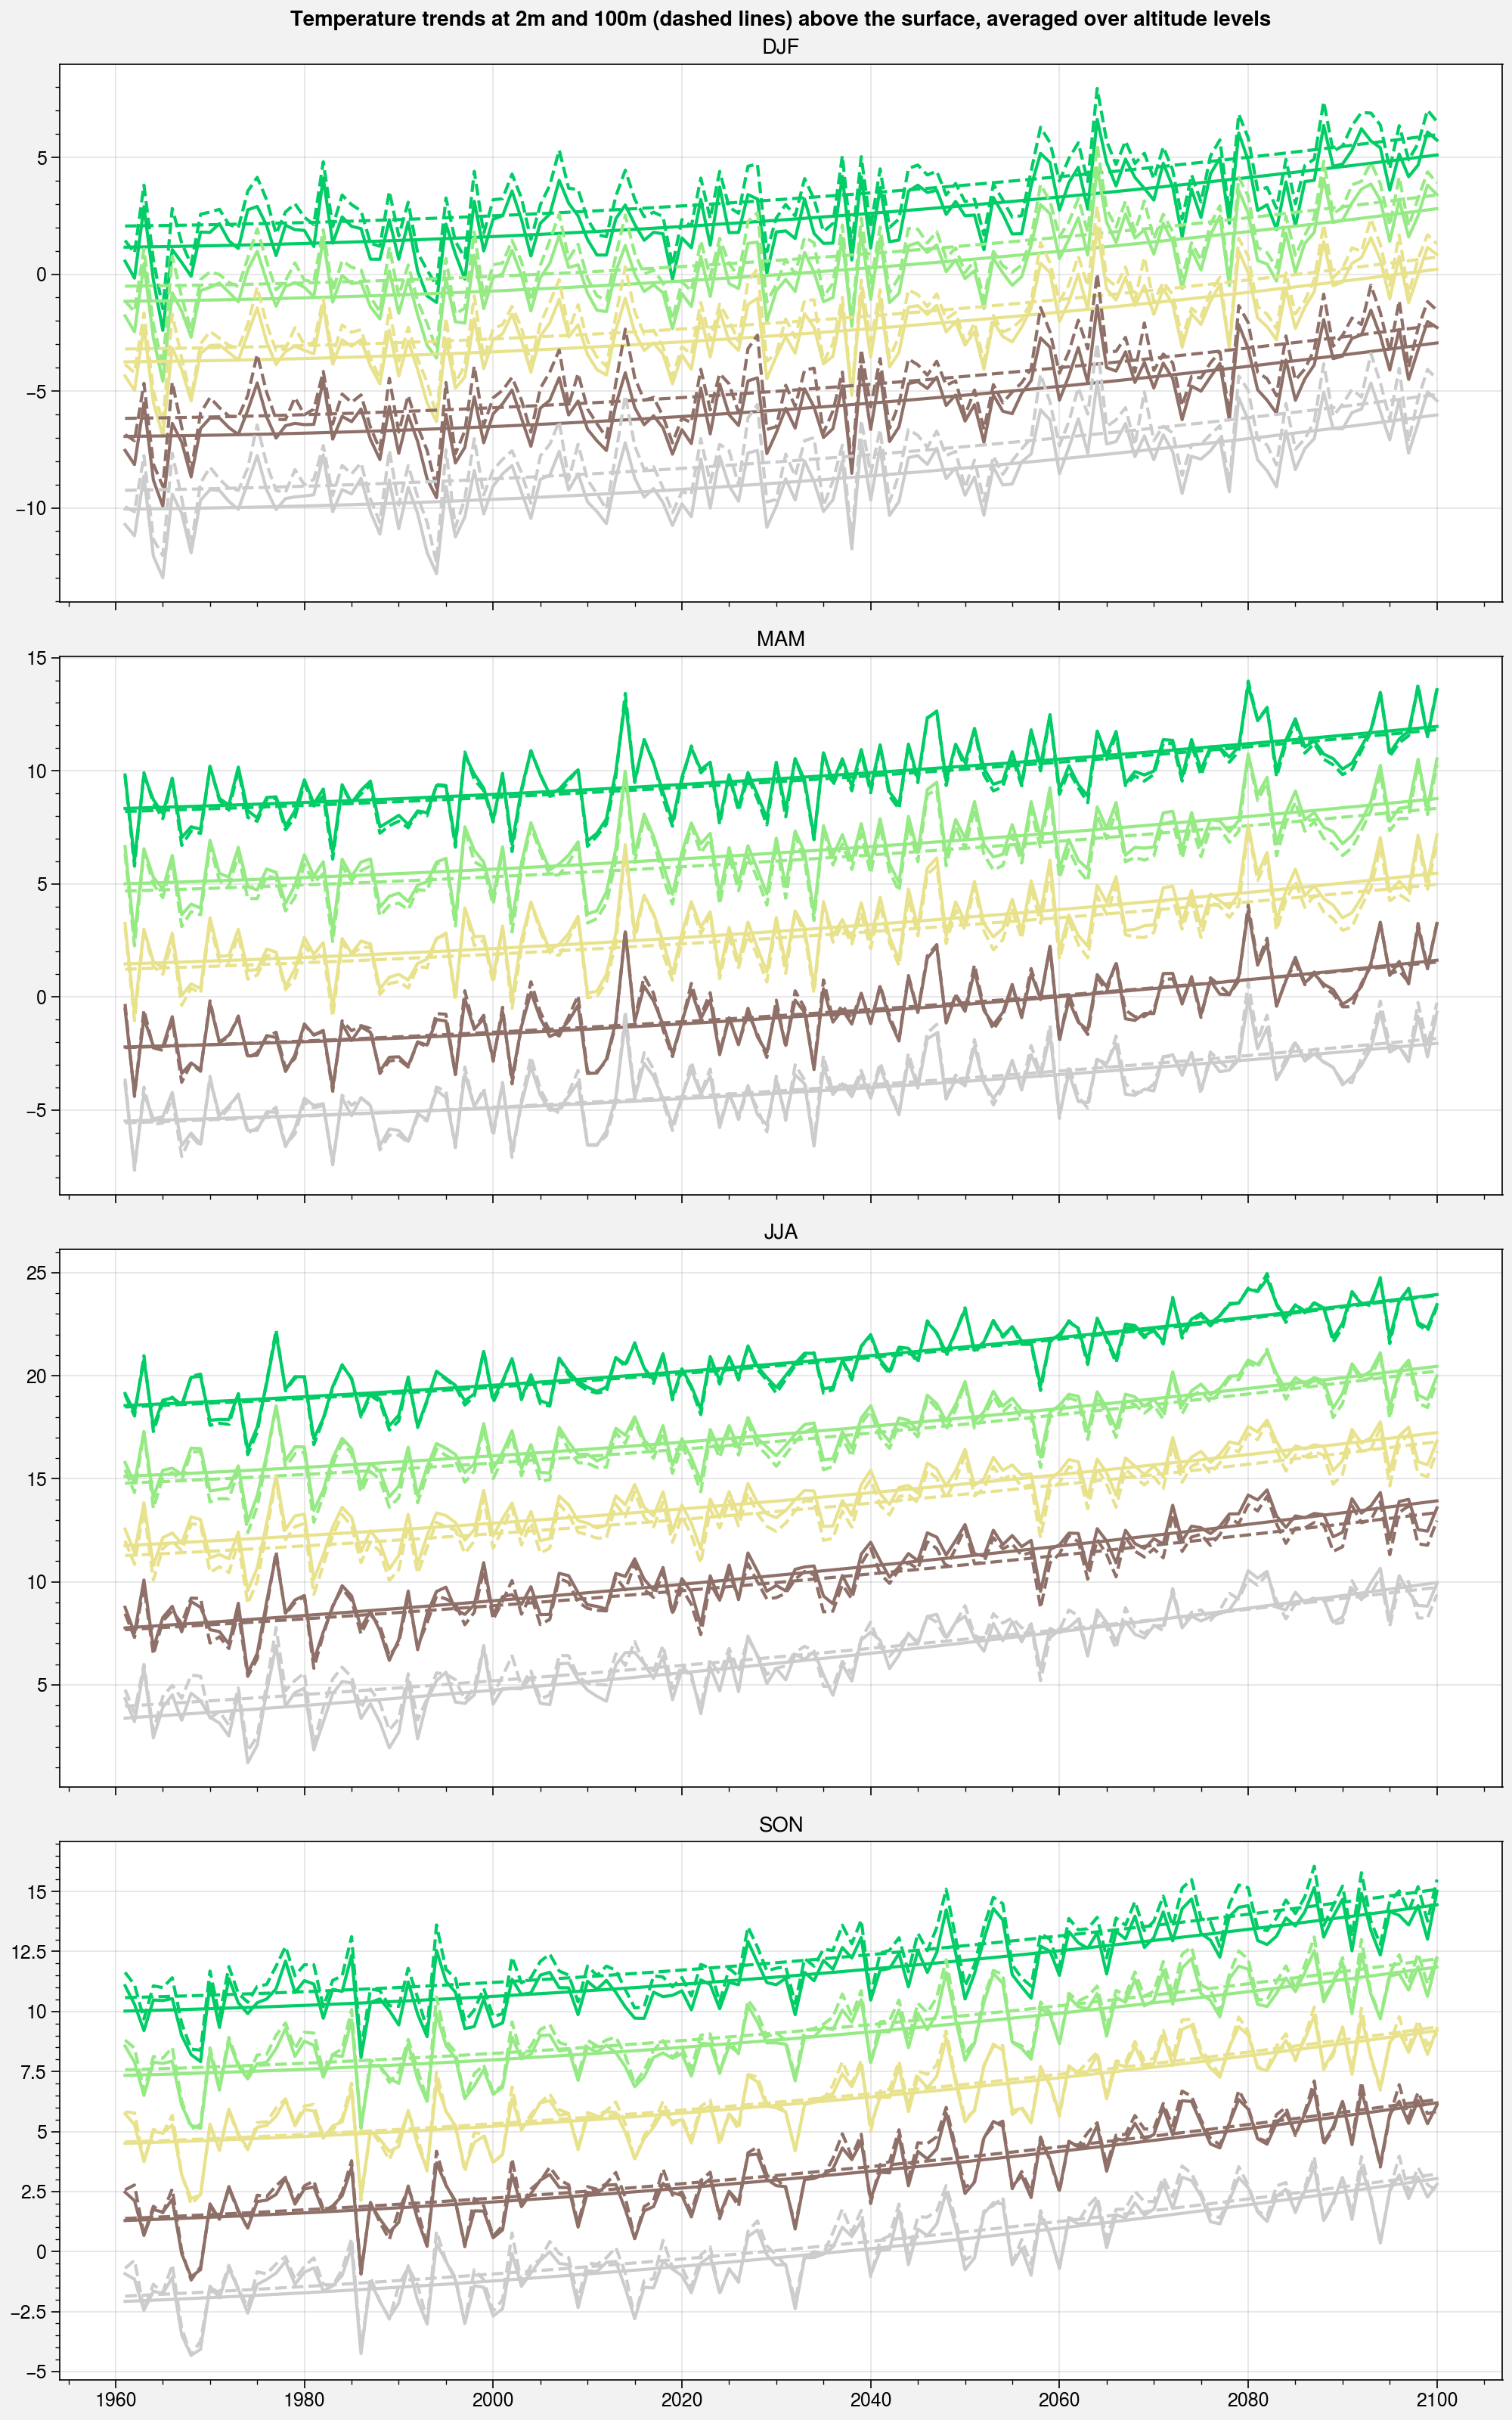

In [26]:

f,axs = pplt.subplots(nrows=4,figsize=(10,16))

for j in range(4):
    for i in range(len(levels)-1):
        axs[j].plot(time,meanseason_meanT_levels[i][:,j],color=color_levels[i])
        axs[j].plot(time,meanseason_meanT_100m_levels[i][:,j],color=color_levels[i],linestyle='--')
        
        a, b, c = np.polyfit(time,meanseason_meanT_levels[i][:,j], 2)
        axs[j].plot(time, a*time**2 + b*time +c,color=color_levels[i])
        
        a, b, c = np.polyfit(time,meanseason_meanT_100m_levels[i][:,j], 2)
        axs[j].plot(time, a*time**2 + b*time +c,'--',color=color_levels[i])
        
    axs[j].set_title(seasons[j])

axs.format(suptitle="Temperature trends at 2m and 100m (dashed lines) above the surface, averaged over altitude levels")

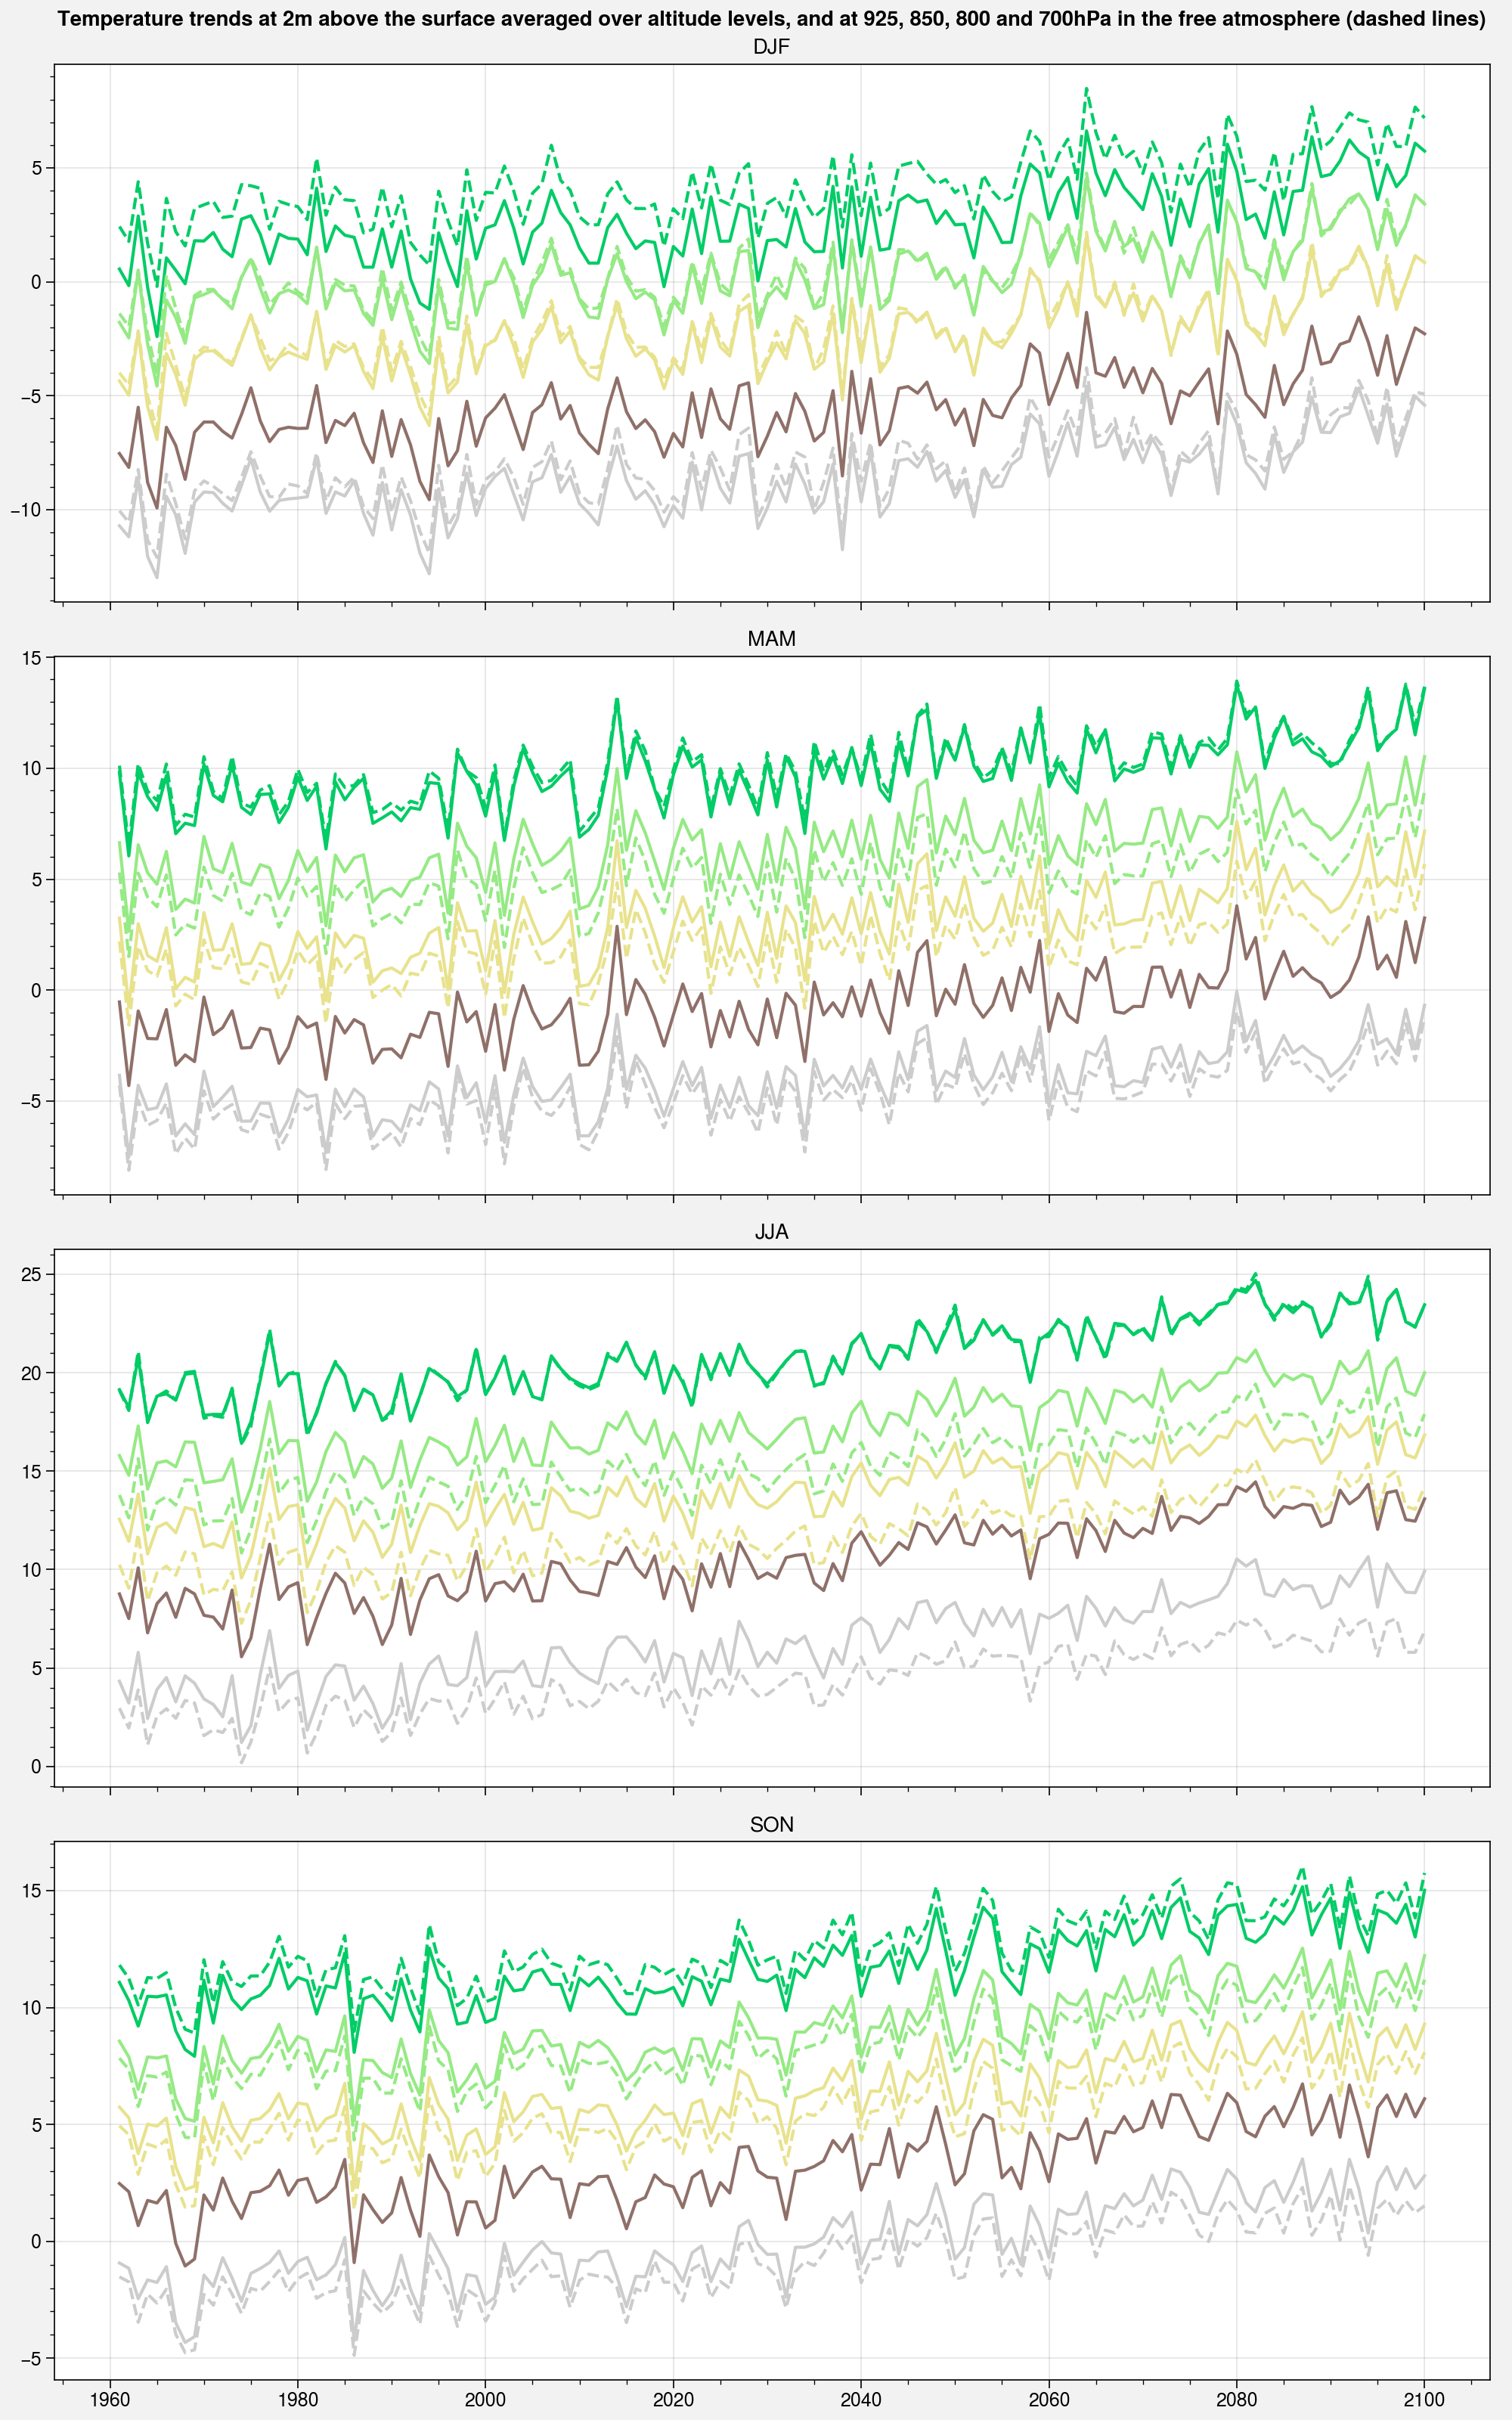

In [27]:
f,axs = pplt.subplots(nrows=4,figsize=(10,16))

for season in range(4):
    for i in range(len(levels)-1):
        axs[season].plot(time,meanseason_meanT_levels[i][:,season],color=color_levels[i])
        
    axs[season].plot(np.arange(1961,2101),wp_meanseason_meanTTp_925_meanalps[:,season],label='925',color=color_levels[0],linestyle='--')
    axs[season].plot(np.arange(1961,2101),wp_meanseason_meanTTp_850_meanalps[:,season],label='850',color=color_levels[1],linestyle='--')
    axs[season].plot(np.arange(1961,2101),wp_meanseason_meanTTp_800_meanalps[:,season],label='800',color=color_levels[2],linestyle='--')
    axs[season].plot(np.arange(1961,2101),wp_meanseason_meanTTp_700_meanalps[:,season],label='700',color=color_levels[4],linestyle='--')
    #axs[season].plot(np.arange(1961,2101),wp_meanseason_meanTTp_600_meanalps[:,season],label='600')

        
    axs[season].set_title(seasons[season])

axs.format(suptitle=
           "Temperature trends at 2m above the surface averaged over altitude levels, and at 925, 850, 800 and 700hPa in the free atmosphere (dashed lines)")

In [ ]:
time = np.linspace(1961,2100,140)
y1,yn = 60,140
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
fig,axs = pplt.subplots(nrows=3,figsize=(12,6), share=False)# ,hratios=(1, 1,1,1) )
for col in range(2):
    for j,v in enumerate([[3,4,5],[0,1,2]][col]):
        for i in range(len(levels)):
            les_delta = np.zeros(12)#len(levels),
            for m,month in enumerate(months):
                if v==2:
                    a, _ = np.polyfit(time[y1:yn],monthly_levels_data[y1:yn,m,i,1]+monthly_levels_data[y1:yn,m,i,2], 1)
                else:
                    a, _ = np.polyfit(time[y1:yn],monthly_levels_data[y1:yn,m,i,v], 1)
                les_delta[m] = a*80
            axs[j,col].plot(months,les_delta,color=color_levels[i])
        axs[j,col].set_title(name_data[v],fontsize=15)
        if v==2:
            axs[j,col].set_title('Rain+Snowfall (mm/d)',fontsize=15)
        if col==0:
            axs[j,col].set_ylim([0,8])
        # else:
        #     axs[j,col].set_ylim([-1,1])

fig.suptitle('French alps climate variations from 2020 to 2100 MAR-MPI',fontsize=20)
fig.legend(handles=[ mpatches.Patch(color=color_levels[i],label=name_levels[i]) for i in range(6)],
          fontsize=15, ncols=6, center=True, frame=False, loc='b')

In [29]:


for
T_month = xr.open_dataset('/bettik/beaumetj/MARout/MAR-MPI-ESM1-2-HR/HIST/monthly/MON.MPI-ESM_HIST.EUy.TTz.2000.nc').TTz[:,0,jmin:jmax,imin:imax]

T_month

<xarray.DataArray 'TTz' (time: 366, y: 91, x: 139)>
[4629534 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 2000-01-01T12:00:00 ... 2000-12-31T12:00:00
  * x        (x) float32 -259.0 -252.0 -245.0 -238.0 ... 686.0 693.0 700.0 707.0
  * y        (y) float32 -168.0 -161.0 -154.0 -147.0 ... 441.0 448.0 455.0 462.0
    ztqlev   float32 2.0
Attributes:
    units:          C
    long_name:      Temperature
    standard_name:  Temperature
    actual_range:   [-20.328133  15.521057]

In [ ]:
T_month_alps = np.ma.array(T_month,mask=np.invert(np.repeat(levels[i][np.newaxis,:,:],12,axis=0)))

meanT_month_alps = T_month_alps.mean(axis=(1,2))

In [34]:
first_year = 2015
last_year = 2100
monthly_levels_data = np.zeros(((last_year-first_year+1),12,len(levels),3))

for year in list(range(first_year,last_year+1)):
    print(year,end=' ')

    path = '/bettik/beaumetj/MARout/MAR-EC-Earth3/SSP245/monthly/MON.EC-Earth3_SSP245.EUe.'
    
    T2 = xr.open_dataset(path+'TTz.'+str(year)+'.nc').TTz[:,0,jmin:jmax,imin:imax]
    T50 = xr.open_dataset(path+'TTz.'+str(year)+'.nc').TTmax[:,2,jmin:jmax,imin:imax]
    T100 = xr.open_dataset(path+'TTz.'+str(year)+'.nc').TTmin[:,3,jmin:jmax,imin:imax]     
    
    alps
    
    T2_alps = np.ma.masked_array(T2,mask=np.invert(np.repeat(levels[i][np.newaxis,:,:],12,axis=0)))
    T50_alps = np.ma.masked_array(T50,mask=np.invert(np.repeat(levels[i][np.newaxis,:,:],12,axis=0)))
    T100_alps = np.ma.masked_array(T100,mask=np.invert(np.repeat(levels[i][np.newaxis,:,:],12,axis=0)))
                               
    iyear = year-first_year
    for i,lev in enumerate(levels):
        flat_lev = lev.reshape(nlon*nlat)
        monthly_levels_data[iyear,:,i,0] = np.sum( SC_flat[:,flat_lev] ,axis=1) /surface_levels[i]
        monthly_levels_data[iyear,:,i,1] = np.sum( SF_flat[:,flat_lev] ,axis=1) /surface_levels[i]
        monthly_levels_data[iyear,:,i,2] = np.sum( R_flat[:,flat_lev] ,axis=1) /surface_levels[i]
        monthly_levels_data[iyear,:,i,3] = np.sum( T_flat[:,flat_lev] ,axis=1) /surface_levels[i]
        monthly_levels_data[iyear,:,i,4] = np.sum( Tmax_flat[:,flat_lev] ,axis=1) /surface_levels[i]
        monthly_levels_data[iyear,:,i,5] = np.sum( Tmin_flat[:,flat_lev] ,axis=1) /surface_levels[i]
        monthly_levels_data[iyear,:,i,6] = np.sum( MB_flat[:,flat_lev] ,axis=1) /surface_levels[i]
        

(12, 12649)

In [35]:
i=0

flat_lev = levels[i].reshape(nlon*nlat)
np.sum( T_flat[:,flat_lev] ,axis=1) /surface_levels[i]

array([ 0.24225783,  0.7406687 ,  3.6237886 ,  7.9369707 , 14.4910145 ,
       18.871483  , 21.576714  , 20.343584  , 14.542394  , 10.6932    ,
        4.9415374 ,  0.4031239 ], dtype=float32)

In [36]:
TTT = np.ma.array(T.groupby("time.month").mean("time"),mask=np.invert(np.repeat(levels[i][np.newaxis,:,:],12,axis=0)))

TTT.mean(axis=(1,2))

masked_array(data=[0.24225751709404583, 0.7406697100903614,
                   3.6237877010273234, 7.936968017157917,
                   14.491027726979347, 18.871480341006883,
                   21.576709740748708, 20.343592001936315,
                   14.542392225150602, 10.693204738597245,
                   4.941541136644793, 0.4031227098684918],
             mask=[False, False, False, False, False, False, False, False,
                   False, False, False, False],
       fill_value=1e+20)

In [37]:
T_month = xr.open_dataset('/bettik/beaumetj/MARout/MAR-MPI-ESM1-2-HR/HIST/monthly/MON.MPI-ESM_HIST.EUy.TTz.2000.nc').TTz[:,0,jmin:jmax,imin:imax]

T_month

<xarray.DataArray 'TTz' (time: 12, y: 91, x: 139)>
[151788 values with dtype=float32]
Coordinates:
  * x        (x) float32 -259.0 -252.0 -245.0 -238.0 ... 686.0 693.0 700.0 707.0
  * y        (y) float32 -168.0 -161.0 -154.0 -147.0 ... 441.0 448.0 455.0 462.0
    ztqlev   float32 2.0
  * time     (time) datetime64[ns] 2000-01-16T12:00:00 ... 2000-12-16T12:00:00
Attributes:
    standard_name:  Temperature
    long_name:      Temperature
    units:          C
    actual_range:   [-25.909277  16.926016]

In [38]:
T_month_alps = np.ma.array(T_month,mask=np.invert(np.repeat(levels[i][np.newaxis,:,:],12,axis=0)))

T_month_alps.mean(axis=(1,2))

masked_array(data=[0.2422574645680938, 0.7406698151422655,
                   3.6237877010273234, 7.936968017157917,
                   14.491027726979347, 18.871480341006883,
                   21.576709740748708, 20.343592001936315,
                   14.542392225150602, 10.693204738597245,
                   4.941541136644793, 0.4031228674463479],
             mask=[False, False, False, False, False, False, False, False,
                   False, False, False, False],
       fill_value=1e+20)